In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Colab\ Notebooks/meme-evolution-main/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/meme-evolution-main


In [2]:
import pandas as pd
import numpy as np

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

In [ ]:
!pip install torchutils
!pip install datasets
!pip install umap-learn

In [ ]:
!pip install adjustText

In [6]:
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Data 3.5 4chan

In [7]:
import json

# Specify the path to the JSON file
json_file = "test.json"

# Open the JSON file for reading
with open(json_file, "r") as f:
    # Load the JSON data
    data = json.load(f)

data[0]['posts'][0]

{'archived_on': 1467306944,
 'replies': 2,
 'images': 0,
 'archived': 1,
 'no': 79299730,
 'fsize': 512134,
 'filename': '1aa06921fa484414de9fcf2b7336a79f',
 'tim': 1467304506063,
 'closed': 1,
 'country_name': 'Israel',
 'bumplimit': 0,
 'time': 1467304506,
 'imagelimit': 0,
 'semantic_url': 'keemstar-should-run-for-public-office',
 'now': '06/30/16(Thu)12:35:06',
 'md5': 'm296nkrANIPqm8zjkIS6TQ==',
 'name': 'Anonymous',
 'tn_w': 250,
 'h': 922,
 'ext': '.jpg',
 'resto': 0,
 'w': 1165,
 'tn_h': 197,
 'country': 'IL',
 'com': 'Keemstar should run for public office.<br><span class="quote">&gt;Everyone lies about him</span><br><span class="quote">&gt;He&#039;s the hero of truth and justice</span><br><span class="quote">&gt;absolutely destroys every lie about him</span><br><span class="quote">&gt;People still don&#039;t believe him</span><br><br>https://www.youtube.com/watch?v=sJk<wbr>0aYg2jAA<br>God bless Keemstar',
 'entities': [{'entity_text': 'Keemstar',
   'entity_start': 0,
   'enti

In [8]:
def find_all_comments_to_dataframe(data):
  """
  This function iterates through all comments in the data structure and saves them to a Pandas DataFrame.

  Args:
      data: A list containing nested dictionaries representing the data.

  Returns:
      A Pandas DataFrame containing columns for no, com, resto, and filename.
  """
  comments = []
  for i in range(len(data)):
    for j in range(data[i]['posts'][0]['replies']):
      post = data[i]['posts'][j]
      if 'com' in post:
        filename = post.get('filename', 'NA')

        comments.append({
          'no': post['no'],
          'com': post['com'],
          'resto': post['resto'],
          'filename': filename
        })
  df = pd.DataFrame(comments)
  return df

In [9]:
chan = find_all_comments_to_dataframe(data)
chan.head()

,no,com,resto,filename
0,79299730,Keemstar should run for public office.<br><spa...,0,1aa06921fa484414de9fcf2b7336a79f
1,79300152,Who?,79299730,NA
2,79290593,Consider the following for those of you that t...,0,image
3,79290672,"<a href=""#p79290593"" class=""quotelink"">&gt;&gt...",79290593,NA
4,79290809,"<span class=""quote"">&gt;Syrian Network for hum...",79290593,NA


In [10]:
len(chan)

38875

In [11]:
chan['filename'].eq('NA').sum()/len(chan)*100

75.67331189710612

## The slur expert

In [12]:
slur_expert = pd.read_csv("kurrek.2020.slur-corpus.csv")
slur_expert.drop(['subreddit', 'author'], axis=1, inplace=True)
slur_expert = slur_expert.dropna(subset=['gold_label'])

In [13]:
slur_expert = slur_expert[slur_expert['gold_label'] != 'CMP']

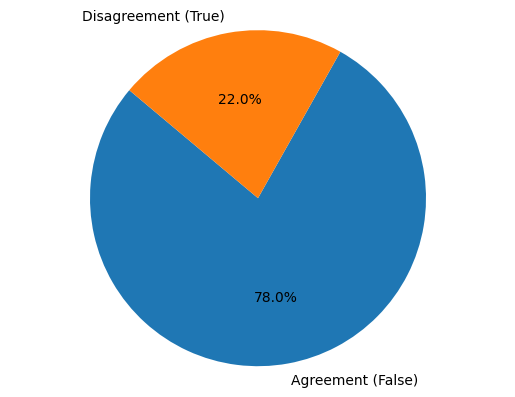

In [14]:
import matplotlib.pyplot as plt

true_count = len(slur_expert[slur_expert['disagreement'] == True])

total_entries = len(slur_expert)
true_proportion = true_count / total_entries

false_proportion = 1 - true_proportion

labels = ['Agreement (False)', 'Disagreement (True)']
sizes = [false_proportion, true_proportion]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()

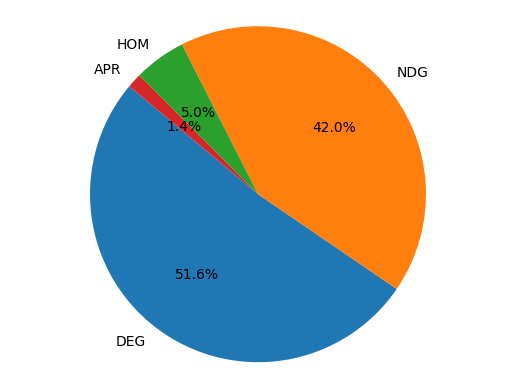

In [15]:
# Calculate the value counts for the 'gold_label' column
value_counts = slur_expert['gold_label'].value_counts()
labels = value_counts.index.tolist()
sizes = value_counts.values.tolist()

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

In [16]:
## For the purposes of this task, the labels are hate speech (Derogratory) x normal (Non Derogatory Non Appropriative, Homonym, Appropriative)

label_mapping = {'DEG': 0, 'NDG': 1, 'HOM': 1, 'APR': 1}
slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)

<ipython-input-16-8e125e821c9f>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)


In [17]:
agreed_slur_expert = slur_expert[slur_expert['disagreement'] == False].copy()

In [18]:
# Function to create synthetic posts
def create_synthetic_posts(df):
    slur_to_post_id = {}
    synthetic_posts = []

    for i, row in df.iterrows():
        slur = row['slur']

        # Check if the synthetic post for this slur already exists
        if slur in slur_to_post_id:
            synthetic_post_id = slur_to_post_id[slur]
        else:
            # Create a new synthetic post ID
            synthetic_post_id = f'synthetic_{slur}'
            slur_to_post_id[slur] = synthetic_post_id

            # Create the synthetic post
            synthetic_post = {
                'id': synthetic_post_id,
                'link_id': row['link_id'],
                'parent_id': '',  # Synthetic post, so no parent
                'score': 0,  # Assuming synthetic posts have a score of 0
                'slur': slur,
                'body': slur,
                'disagreement': False,
                'gold_label': 1
            }
            synthetic_posts.append(synthetic_post)

        # Update the parent_id of the comment to the synthetic post ID
        df.at[i, 'parent_id'] = synthetic_post_id

    # Create a DataFrame for synthetic posts and concatenate with the original DataFrame
    synthetic_df = pd.DataFrame(synthetic_posts)
    return pd.concat([df, synthetic_df], ignore_index=True)

# Create synthetic posts and update the DataFrame
agreed_df = create_synthetic_posts(agreed_slur_expert)
agreed_df.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,Fuck that I dont wanna watch tranny porn.,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,Opie just wanted to have a good time. The same...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,Fuck that faggot Fallon. Fucking sissy boy act...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,BbBB...b.b..b.bb but OP's a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,Who even uses the word tranny except for trans...,False,1


In [19]:
agreed_df.parent_id.unique()

array(['synthetic_tranny', 'synthetic_faggot', 'synthetic_nigger', ''],
      dtype=object)

In [20]:
test_df = agreed_df.sample(n=1000).reset_index()
test_df = create_synthetic_posts(test_df)

test_df = test_df[['body','gold_label']]
test_df.head()

,body,gold_label
0,Today the OP was not a faggot on a technicality.,0
1,"Really, everything is about free speech for th...",1
2,"yeah because I'm sure you say ""nigger"" instead...",1
3,"Nice repost, faggot",0
4,iChan 4:\n\n\n\n\nNigger Nigger Nigger Nigger ...,0


In [21]:
# Get data

slur_df = agreed_slur_expert[['body','gold_label']]

In [22]:
from sklearn.model_selection import train_test_split

trainDF, testDF = train_test_split(slur_df, test_size=0.2, random_state=42)

# Reset the indices of train_df and test_df
trainDF.reset_index(drop=True, inplace=True)
testDF.reset_index(drop=True, inplace=True)

print("Training dataset shape:", trainDF.shape)
print("Testing dataset shape:", testDF.shape)

print(trainDF.head())

Training dataset shape: (24826, 2)
Testing dataset shape: (6207, 2)
                                                body  gold_label
0  &gt; yeah i think it's just about time to wrap...           1
1  ofc, I think thats kinda the natural way, My d...           0
2  Great, then a new word will come up. It still ...           1
3  By that logic, it's perfectly alright to call ...           1
4  I have no problemm with the transgenderes they...           0


In [23]:
x_train = trainDF['body'].tolist()
y_train = trainDF['gold_label'].tolist()

x_test = testDF['body'].tolist()
y_test = testDF['gold_label'].tolist()

In [24]:
trainDF, testDF = train_test_split(test_df, test_size=0.2, random_state=42)

train_x = trainDF['body'].tolist()
train_y = trainDF['gold_label'].tolist()

test_x = testDF['body'].tolist()
test_y = testDF['gold_label'].tolist()

## Sarcasm Dataset

In [25]:
sarcasm_expert = pd.read_csv("train.En.csv")
sarcasm_expert.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sarcasm_df = pd.DataFrame(columns=["text", "label"])

for index, row in sarcasm_expert.iterrows():

  sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["tweet"]], "label": [1]})], ignore_index=True)

  # Add rephrased non-sarcastic tweet (label 0) if it exists
  if pd.notnull(row["rephrase"]):
    sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["rephrase"]], "label": [0]})], ignore_index=True)

# Add non-sarcastic tweets
non_sarcastic_tweets = sarcasm_expert[sarcasm_expert["sarcastic"] == 0]
non_sarcastic_tweets = non_sarcastic_tweets.rename(columns={"tweet": "text", "sarcastic": "label"})
sarcasm_df = pd.concat([sarcasm_df, non_sarcastic_tweets[["text", "label"]]], ignore_index=True)

sarcasm_df["text"] = sarcasm_df["text"].astype(str)
sarcasm_df["label"] = sarcasm_df["label"].astype(int)

# View the first few rows of sarcasm_df
sarcasm_df.head()

,text,label
0,The only thing I got from college is a caffein...,1
1,"College is really difficult, expensive, tiring...",0
2,I love it when professors draw a big question ...,1
3,I do not like when professors don’t write out ...,0
4,Remember the hundred emails from companies whe...,1


## Validation df

In [27]:
val_df = pd.read_csv("HS expert.csv", header=None)
val_df[0] = val_df[0].astype(str)

In [28]:
val_df.rename(columns={0: 'text'}, inplace=True)
val_df.rename(columns={1: 'label'}, inplace=True)

## Preprocessing

In [29]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
!pip install wordcloud

In [31]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re

tok = WordPunctTokenizer()

def clean_text(text):
  """
  Cleans text by removing HTML tags, numbers, punctuation (except .,!?(), /), and extra spaces.
  Maintains repetition of parentheses.

  Args:
      text (str): The text to be cleaned.

  Returns:
      str: The cleaned text.
  """
  text = re.sub(r'\>>\d+', '', text)
  # Remove HTML tags
  text = re.sub("\'", "", text)
  # Remove numbers
  text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  # Remove smart quotes
  text = re.sub("(?<=\w)[‘`’'](?=\w)", '', text)
  # Replace greater than symbol with space
  text = re.sub(r'&gt;', ' ', text)
  # Remove HTML tags again (in case nested)
  text = re.sub(r'<[^>]*>', ' ', text)
  text = re.sub(r'[^\w\s()]|http\S+', '', text)
  # Lowercase text
  text = text.lower()
  # Remove non-alphanumeric characters except for .,!?(), / and keep repeated parenthesis
  text = re.sub(r'[^\w\s\.,!?\\]+|[\(\)]', "", text)
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def preprocess_comments(comments):
  # Make all words lowercase (combine steps 1 & 2)
  comments2 = comments.apply(clean_text)

  # Tokenization
  tokenized_comments = []
  for comment in comments2:
      tokenized_comments.append(tok.tokenize(comment))

  # Remove stopwords using set comprehension
  stop_words = set(stopwords.words("english"))
  tokenized_comments2 = [
      [word for word in comment if word.lower() not in stop_words]
      for comment in tokenized_comments
  ]

  # Count the frequency of each word
  word_counts = Counter([word for comment in tokenized_comments2 for word in comment])

  return comments2, tokenized_comments2, word_counts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [32]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [33]:
#read extracted data
df_posts = agreed_df
df_posts['body'] = df_posts['body'].apply(clean_text)
df_posts.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,fuck that i dont wanna watch tranny porn,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,opie just wanted to have a good time the same ...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,fuck that faggot fallon fucking sissy boy acti...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,bbbbbbbbb but ops a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,who even uses the word tranny except for trans...,False,1


In [34]:
len(df_posts)

31036

In [35]:
# Tokenize the comments
train_comments = df_posts.body.astype(str)
train_comments, train_tc, train_wc = preprocess_comments(train_comments)


In [36]:
# read extracted data
df_posts2 = chan.copy()
# Remove citations from comments
df_posts2['com'] = df_posts2['com'].apply(clean_text)

train_comments2 = df_posts2.com.astype(str)
train_comments2, train_tc2, train_wc2 = preprocess_comments(df_posts2.com.astype(str))



In [37]:
# read extracted data
df_posts3 = sarcasm_df.copy()
# Remove citations from comments
df_posts3['text'] = df_posts3['text'].apply(clean_text)

train_comments3 = df_posts3.text.astype(str)
train_comments3, train_tc3, train_wc3 = preprocess_comments(df_posts3.text.astype(str))


In [38]:
val_df['text'] = val_df['text'].apply(clean_text)

val_com = val_df.text.astype(str)
val_com, val_tc, val_wc = preprocess_comments(val_df.text.astype(str))

## Data preparing

In [39]:
slur_test = df_posts[21000:22000]
df_posts = df_posts[0:10000]
df_posts3 = df_posts3[0:10000]

In [40]:
distribution_percentage = df_posts['gold_label'].value_counts(normalize=True) * 100
print(distribution_percentage)

gold_label
0    65.8
1    34.2
Name: proportion, dtype: float64


In [41]:
distribution_percentage = slur_test['gold_label'].value_counts(normalize=True) * 100
print(distribution_percentage)

gold_label
0    50.9
1    49.1
Name: proportion, dtype: float64


In [42]:
distribution_percentage = df_posts3['label'].value_counts(normalize=True) * 100
print(distribution_percentage)

label
1    50.0
0    50.0
Name: proportion, dtype: float64


In [43]:
import torch
from transformers import BertTokenizer, BertModel, GraphormerConfig, GraphormerForGraphClassification
from nltk.tokenize import sent_tokenize
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm
import gc
import os

# Load tokenizer and model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [44]:
def tokenize_sentences(sentences):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
            max_length=128,                # Pad & truncate all sentences
            padding='max_length',
            return_attention_mask=True,    # Construct attention masks
            return_tensors='pt',           # Return pytorch tensors
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids, attention_masks = tokenize_sentences(df_posts['body'])
labels = torch.tensor(df_posts['gold_label'].values).to(device)

In [45]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_token_embeddings(model, input_ids, attention_masks, batch_size=32):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), desc="Getting token embeddings"):
            batch_input_ids = input_ids[i:i+batch_size].to(device)  # Move tensors to the device
            batch_attention_masks = attention_masks[i:i+batch_size].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            embeddings = outputs.last_hidden_state.cpu()  # Move embeddings back to CPU

            all_embeddings.append(embeddings)

            del batch_input_ids, batch_attention_masks, outputs
            torch.cuda.empty_cache()
            gc.collect()

    return torch.cat(all_embeddings, dim=0)

embeddings = get_token_embeddings(bert_model, input_ids, attention_masks)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Getting token embeddings: 100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


In [46]:
torch.cuda.empty_cache()
gc.collect()

0

In [47]:
slur_input_ids, slur_attention_masks = tokenize_sentences(slur_test['body'])
slur_labels = torch.tensor(slur_test['gold_label'].values).to(device)
slur_input_ids = slur_input_ids.to(device)
slur_attention_masks = slur_attention_masks.to(device)

slur_embeddings = get_token_embeddings(bert_model, slur_input_ids, slur_attention_masks)

Getting token embeddings: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


In [48]:
#for sarcasm

sarc_input_ids, sarc_attention_masks = tokenize_sentences(df_posts3['text'])
sarc_labels = torch.tensor(df_posts3['label'].values).to(device)
sarc_input_ids = sarc_input_ids.to(device)
sarc_attention_masks = sarc_attention_masks.to(device)

text_column = 'text'
label_column = 'label'
sarc_embeddings = get_token_embeddings(bert_model, sarc_input_ids, sarc_attention_masks)

Getting token embeddings: 100%|██████████| 217/217 [02:00<00:00,  1.80it/s]


In [49]:
val_input_ids, val_attention_masks = tokenize_sentences(val_df["text"])
val_labels = torch.tensor(val_df["label"].values).to(device)
val_input_ids = val_input_ids.to(device)
val_attention_masks = val_attention_masks.to(device)

val_embeddings = get_token_embeddings(bert_model, val_input_ids, val_attention_masks)

Getting token embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


## Graphormer

In [50]:
import dgl

In [51]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

In [52]:
def normalize_embeddings(embeddings):
    # Min-max normalize the embeddings to the range [0, 1]
    min_val = embeddings.min(dim=-1, keepdim=True)[0]
    max_val = embeddings.max(dim=-1, keepdim=True)[0]
    normalized_embeddings = (embeddings - min_val) / (max_val - min_val + 1e-5)
    return normalized_embeddings

def quantize_embeddings(normalized_embeddings, num_bins=256):
    # Quantize the normalized embeddings to discrete values
    quantized_embeddings = (normalized_embeddings * (num_bins - 1)).long()
    return quantized_embeddings

# Normalize embeddings
normalized_embeddings = normalize_embeddings(embeddings)

# Quantize embeddings
num_bins = 256
quantized_embeddings = quantize_embeddings(normalized_embeddings, num_bins=num_bins)

In [53]:
def create_dgl_graphs(df_posts, input_ids, attention_masks, embeddings_list, text_column='body',
                     label_column='gold_label', num_classes=2):
    """
    Create DGL graphs from text data with configurable column names.

    Returns:
        tuple: (list of DGL graphs, tensor of labels)
    """
    # Load spaCy English model
    nlp = spacy.load("en_core_web_sm")

    graphs = []
    labels = []

    for i in range(len(df_posts)):
        sentence = df_posts[text_column].iloc[i]
        mask = attention_masks[i]
        num_tokens = int(mask.sum())

        # Create graph
        g = dgl.graph(([], []), num_nodes=num_tokens)

        # Add sequential edges
        src = list(range(num_tokens - 1))
        dst = list(range(1, num_tokens))
        g.add_edges(src, dst)
        g.add_edges(dst, src)

        # Perform dependency parsing
        doc = nlp(sentence)

        # Add dependency edges
        for token in doc:
            if token.i < num_tokens and token.head.i < num_tokens:
                g.add_edges(token.i, token.head.i)
                g.add_edges(token.head.i, token.i)

        # Assign node features (use embeddings for valid tokens only)
        node_features = embeddings_list[i].clone().detach()[:num_tokens]
        g.ndata['feat'] = node_features

        # Add edge types
        edge_types = []
        for u, v in zip(g.edges()[0], g.edges()[1]):
            if abs(int(u) - int(v)) == 1:
                edge_types.append(0)  # Sequential edge
            else:
                edge_types.append(1)  # Dependency edge
        g.edata['type'] = torch.tensor(edge_types)

        # Add graph-level attributes
        g.graph_data = {
            'original_text': sentence,
        }

        graphs.append(g)
        labels.append(df_posts[label_column].iloc[i])

    labels = torch.tensor(labels)  # Convert labels to a tensor
    return graphs, labels

graphs, labels = create_dgl_graphs(df_posts, input_ids, attention_masks, quantized_embeddings)

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def collate_fn(batch):
    graphs, labels = zip(*batch)

    num_graphs = len(graphs)
    num_nodes = [g.num_nodes() for g in graphs]
    max_num_nodes = max(num_nodes)

    # Initialize the tensors to store the batched graph data
    attn_mask = torch.zeros(num_graphs, max_num_nodes + 1, max_num_nodes + 1, dtype=torch.bool)
    node_feat = []
    in_degree, out_degree = [], []
    spatial_pos = torch.zeros(num_graphs, max_num_nodes, max_num_nodes, dtype=torch.long)
    attn_edge_type = torch.zeros(num_graphs, max_num_nodes, max_num_nodes, 12, dtype=torch.long)
    attn_bias = torch.zeros((num_graphs, max_num_nodes + 1, max_num_nodes + 1), dtype=torch.long)

    for i in range(num_graphs):
        g = graphs[i]
        num_nodes_i = num_nodes[i]

        # Set attention mask for valid nodes
        attn_mask[i, :num_nodes_i + 1, :num_nodes_i + 1] = 1

        node_feat.append(g.ndata["feat"])

        in_degree.append(torch.clamp(g.in_degrees(), min=0, max=511))
        out_degree.append(torch.clamp(g.out_degrees(), min=0, max=511))

        # Compute shortest path distances
        spd = dgl.shortest_dist(g)
        spatial_pos[i, :num_nodes_i, :num_nodes_i] = torch.clamp(spd, max=511)

        # Set edge types
        edge_type = g.edata['type']
        edge_index = g.edges()
        expanded_edge_type = edge_type.unsqueeze(-1).expand(-1, 12)
        attn_edge_type[i, edge_index[0], edge_index[1], :] = expanded_edge_type

    # Node feature padding
    node_feat = pad_sequence(node_feat, batch_first=True)

    # Degree padding
    in_degree = pad_sequence(in_degree, batch_first=True)
    out_degree = pad_sequence(out_degree, batch_first=True)

    # Convert labels to tensor
    labels = torch.stack(labels)

    return (
        attn_mask,
        node_feat,
        in_degree,
        out_degree,
        spatial_pos,
        attn_edge_type,
        attn_bias,
        labels,
    )

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [54]:
# Assuming GraphDataset class is already defined
dataset = GraphDataset(graphs, labels)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [55]:
for batch in data_loader:
    attn_mask, node_feat, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

    # Print the dimensions of each tensor in the batch
    print(f"attn_mask: {attn_mask.shape}")
    print(f"node_feat: {node_feat.shape}")
    print(f"in_degree: {in_degree.shape}")
    print(f"out_degree: {out_degree.shape}")
    print(f"spatial_pos: {spatial_pos.shape}")
    print(f"attn_edge_type: {attn_edge_type.shape}")
    print(f"attn_bias: {attn_bias.shape}")
    print(f"labels: {labels.shape}")
    print("-" * 20)

    break

attn_mask: torch.Size([16, 56, 56])
node_feat: torch.Size([16, 55, 768])
in_degree: torch.Size([16, 55])
out_degree: torch.Size([16, 55])
spatial_pos: torch.Size([16, 55, 55])
attn_edge_type: torch.Size([16, 55, 55, 12])
attn_bias: torch.Size([16, 56, 56])
labels: torch.Size([16])
--------------------


In [56]:
torch.cuda.empty_cache()
gc.collect()

14916

In [57]:
slur_normalized_embeddings = normalize_embeddings(slur_embeddings)

# Quantize embeddings
num_bins = 256
slur_quantized_embeddings = quantize_embeddings(slur_normalized_embeddings, num_bins=num_bins)
slur_graphs, slur_labels = create_dgl_graphs(slur_test, slur_input_ids, slur_attention_masks, slur_quantized_embeddings)

slur_dataset = GraphDataset(slur_graphs, slur_labels)
slur_data_loader = DataLoader(slur_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [58]:
torch.cuda.empty_cache()
gc.collect()

8389

In [59]:
import torch
from transformers import GraphormerConfig, GraphormerForGraphClassification
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from tqdm import tqdm
from torch import nn

config = GraphormerConfig(
    num_classes=1,              # Binary classification
    hidden_size=768,
    num_attention_heads=8,      # Reduced from 12 for better local pattern capture
    num_hidden_layers=6,        # Reduced from 12 for faster training and less overfitting
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    edge_type="multi",
    num_edge_types=2,
    multi_hop_max_dist=4,
    ignore_mismatched_sizes=True,
    use_checkpoint=True,
    # Additional parameters for text-specific tasks
    max_position_embeddings=512,  # Maximum sequence length
    layer_norm_eps=1e-5,         # Smaller epsilon for better numerical stability
)

# Optimized training parameters
training_args = {
    'learning_rate': 1e-4,
    'weight_decay': 0.01,
    'warmup_steps': 100,
    'gradient_accumulation_steps': 4,
    'max_grad_norm': 0.5,      # Reduced from 1.0 for more stable training
    'batch_size': 16,          # Increased from 2 for better gradient estimates
}

class HateSpeechGraphormer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.graphormer = GraphormerForGraphClassification(config)

        # Node embedding processing
        self.node_embedding_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(0.2)

        # Initialize node_aggregation with correct input size
        # Changed from config.hidden_size to 1 since we're processing logits
        self.node_aggregation = nn.Linear(1, 1)

        # Add pooling layer for graph-level representation
        self.pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Dropout(0.2)
        )

        # Diversity-aware classifier
        self.classifier = DiversityAwareClassifier(config)

    def forward(
        self,
        input_nodes=None,
        input_edges=None,
        attn_bias=None,
        in_degree=None,
        out_degree=None,
        spatial_pos=None,
        attn_edge_type=None,
        return_dict=True,
    ):
        # Get base Graphormer outputs
        outputs = self.graphormer(
            input_nodes=input_nodes,
            input_edges=input_edges,
            attn_bias=attn_bias,
            in_degree=in_degree,
            out_degree=out_degree,
            spatial_pos=spatial_pos,
            attn_edge_type=attn_edge_type,
            return_dict=True,
            output_hidden_states=True,
        )

        last_hidden_state = outputs.hidden_states[-1].transpose(0, 1)  # [16, 56, 768]

        # Process node embeddings with correct shape
        node_embeddings = self.node_embedding_proj(last_hidden_state)  # [16, 56, 768]
        node_embeddings = self.layer_norm(node_embeddings)
        node_embeddings = self.dropout(node_embeddings)

        # Create graph-level embedding using mean pooling over the sequence dimension
        graph_embedding = torch.mean(node_embeddings, dim=1)  # [16, 768]

        # Handle logits shape
        if hasattr(outputs, 'logits'):
            # Reshape logits for proper processing
            logits = outputs.logits  # Original shape
            logits = logits.view(-1, 1)  # Reshape to [batch_size, 1]
            logits = self.node_aggregation(logits)  # Process through linear layer
            logits = logits.squeeze(-1)  # Final shape [batch_size]
        else:
            # If no logits from base model, create them from graph embedding
            logits = self.classifier.graph_prediction_head(graph_embedding)  # [16, 1]
            logits = logits.squeeze(-1)  # [16]

        # Get diversity scores and attention weights
        _, diversity_scores, attention_weights = self.classifier(node_embeddings, graph_embedding)

        if not return_dict:
            return (logits, node_embeddings, diversity_scores)

        return GraphormerOutputWithEmbeddings(
            logits=logits,
            node_embeddings=node_embeddings,
            diversity_scores=diversity_scores,
            attention_weights=attention_weights,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [60]:
def create_model_and_optimizer(config, device):
    model = HateSpeechGraphormer(config).to(device)

    # Separate parameter groups for different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': training_args['weight_decay']
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=training_args['learning_rate']
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-6
    )

    return model, optimizer, scheduler


In [61]:
from transformers import GraphormerConfig, GraphormerForGraphClassification
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class GraphormerOutputWithEmbeddings:
    """
    Custom output class to include both logits and node embeddings
    """
    logits: torch.FloatTensor
    node_embeddings: Optional[torch.FloatTensor] = None
    diversity_scores: Optional[torch.FloatTensor] = None
    attention_weights: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

class DiversityAwareAttention(nn.Module):
    """
    Attention mechanism that considers node diversity when computing attention scores
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.diversity_proj = nn.Linear(hidden_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, node_embeddings, diversity_scores):
        # Project diversity scores to attention space
        diversity_attention = self.diversity_proj(node_embeddings) * diversity_scores.unsqueeze(-1)

        # Apply attention mechanism
        attended_features, attention_weights = self.attention(
            node_embeddings,
            diversity_attention,
            diversity_attention
        )

        # Residual connection and layer norm
        output = self.layer_norm(node_embeddings + attended_features)
        return output, attention_weights

class DiversityAwareClassifier(nn.Module):
    """
    Classification head that integrates node diversity information
    """
    def __init__(self, config):
        super().__init__()
        self.diversity_attention = DiversityAwareAttention(config.hidden_size)

        # Diversity-aware feature extraction
        self.node_diversity_encoder = nn.Sequential(
            nn.Linear(config.hidden_size * 2, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2)
        )

        # Add graph-level prediction head
        self.graph_prediction_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size // 2, 1)  # Binary classification
        )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.hidden_size, config.num_classes)
        )

    def compute_diversity_scores(self, node_embeddings):
        """
        Compute pairwise diversity scores between nodes
        """
        # Compute pairwise similarities, normalize and compute diversity
        sim_matrix = torch.matmul(node_embeddings, node_embeddings.transpose(-2, -1))
        attention_weights = F.softmax(sim_matrix / torch.sqrt(torch.tensor(node_embeddings.size(-1))), dim=-1)
        diversity_scores = -torch.sum(attention_weights * torch.log(attention_weights + 1e-10), dim=-1)
        return diversity_scores, attention_weights

    def forward(self, node_embeddings, graph_embedding):
        # Compute diversity scores for nodes
        diversity_scores, attention_weights = self.compute_diversity_scores(node_embeddings)

        diversity_features, div_attention_weights = self.diversity_attention(node_embeddings, diversity_scores)

        logits = self.graph_prediction_head(graph_embedding)  # [batch_size, 1]


        return logits.squeeze(-1), diversity_scores, attention_weights

In [62]:
from sklearn.metrics import classification_report, roc_auc_score
from torch.cuda.amp import GradScaler, autocast

def calculate_diversity_metrics(diversity_scores, labels):
    """
    Calculate metrics related to diversity scores
    """
    hate_scores = diversity_scores[labels == 1].mean().item()
    normal_scores = diversity_scores[labels == 0].mean().item()
    diversity_auc = roc_auc_score(labels.cpu(), diversity_scores.cpu())

    return {
        'hate_diversity': hate_scores,
        'normal_diversity': normal_scores,
        'diversity_auc': diversity_auc,
        'diversity_gap': normal_scores - hate_scores
    }

In [63]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics for model evaluation

    Args:
        y_true (list): Ground truth labels
        y_pred (list): Predicted labels

    Returns:
        dict: Dictionary containing various classification metrics
    """
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)

    # Try to calculate AUC-ROC if predictions are binary
    try:
        auc_roc = roc_auc_score(y_true, y_pred)
    except:
        auc_roc = None

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    if auc_roc is not None:
        metrics['auc_roc'] = auc_roc

    return metrics

In [64]:
from dataclasses import dataclass
from typing import Dict, List
from pathlib import Path
import json
from sklearn.metrics import roc_curve, auc, fbeta_score, precision_recall_fscore_support, accuracy_score, roc_auc_score

@dataclass
class ExtendedTrainingMetrics:
    # Basic losses
    classification_loss: float
    diversity_loss: float
    diversity_gap: float

    # ROC and AUC metrics
    roc_fpr: List[float]
    roc_tpr: List[float]
    auroc: float

    # F-scores
    f1_score: float
    f0_5_score: float

    # Per-class metrics
    class_0_precision: float
    class_0_recall: float
    class_0_f1: float
    class_0_accuracy: float
    class_1_precision: float
    class_1_recall: float
    class_1_f1: float
    class_1_accuracy: float

@dataclass
class ValidationMetrics:
    hate_diversity: float
    normal_diversity: float
    diversity_auc: float

@dataclass
class EpochMetrics:
    training: ExtendedTrainingMetrics
    validation: ValidationMetrics

    def to_dict(self):
        # Convert numpy arrays to lists for JSON serialization
        training_dict = {
            'classification_loss': self.training.classification_loss,
            'diversity_loss': self.training.diversity_loss,
            'diversity_gap': self.training.diversity_gap,
            'roc_fpr': self.training.roc_fpr,
            'roc_tpr': self.training.roc_tpr,
            'auroc': self.training.auroc,
            'f1_score': self.training.f1_score,
            'f0_5_score': self.training.f0_5_score,
            'class_0': {
                'precision': self.training.class_0_precision,
                'recall': self.training.class_0_recall,
                'f1': self.training.class_0_f1,
                'accuracy': self.training.class_0_accuracy
            },
            'class_1': {
                'precision': self.training.class_1_precision,
                'recall': self.training.class_1_recall,
                'f1': self.training.class_1_f1,
                'accuracy': self.training.class_1_accuracy
            }
        }

        validation_dict = {
            'hate_diversity': self.validation.hate_diversity,
            'normal_diversity': self.validation.normal_diversity,
            'diversity_auc': self.validation.diversity_auc
        }

        return {
            'training': training_dict,
            'validation': validation_dict
        }

def calculate_extended_metrics(y_true, y_pred, y_scores=None):
    """
    Calculate extended classification metrics including per-class metrics

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        y_scores: Prediction scores/probabilities for ROC curve
    """
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate ROC curve and AUROC if scores are provided
    if y_scores is not None:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auroc = auc(fpr, tpr)
        # Convert to list for JSON serialization
        fpr = fpr.tolist()
        tpr = tpr.tolist()
    else:
        fpr, tpr, auroc = [], [], 0.0

    # Calculate F0.5 score
    f0_5 = fbeta_score(y_true, y_pred, beta=0.5)

    # Calculate per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    # Calculate per-class accuracy
    class_0_mask = y_true == 0
    class_1_mask = y_true == 1

    class_0_accuracy = accuracy_score(y_true[class_0_mask], y_pred[class_0_mask]) if any(class_0_mask) else 0.0
    class_1_accuracy = accuracy_score(y_true[class_1_mask], y_pred[class_1_mask]) if any(class_1_mask) else 0.0

    return ExtendedTrainingMetrics(
        classification_loss=0.0,  # Will be set later
        diversity_loss=0.0,      # Will be set later
        diversity_gap=0.0,       # Will be set later
        roc_fpr=fpr,
        roc_tpr=tpr,
        auroc=auroc,
        f1_score=f1.mean(),
        f0_5_score=f0_5,
        class_0_precision=precision[0],
        class_0_recall=recall[0],
        class_0_f1=f1[0],
        class_0_accuracy=class_0_accuracy,
        class_1_precision=precision[1],
        class_1_recall=recall[1],
        class_1_f1=f1[1],
        class_1_accuracy=class_1_accuracy
    )

class MetricsTracker:
    def __init__(self, save_dir: str = 'metrics'):
        self.metrics_history: List[EpochMetrics] = []
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)

    def add_epoch_metrics(self, epoch_metrics: EpochMetrics):
        self.metrics_history.append(epoch_metrics)

    def save_metrics(self):
        metrics_file = self.save_dir / 'training_metrics.json'
        metrics_dict = {
            'epochs': [metrics.to_dict() for metrics in self.metrics_history]
        }
        with open(metrics_file, 'w') as f:
            json.dump(metrics_dict, f, indent=2)

In [65]:
from torch.utils.data import DataLoader

class DiversityLoss(torch.nn.Module):
    def __init__(self, num_classes=2, alpha=1.0, beta=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred_logits, target, node_embeddings, diversity_scores):
        # Ensure pred_logits has shape [batch_size, num_classes]
        if pred_logits.dim() == 1:
            pred_logits = pred_logits.unsqueeze(-1)
            # For binary classification, create complementary logits
            pred_logits = torch.cat([1 - pred_logits, pred_logits], dim=1)

        # Ensure target is long type for cross entropy
        target = target.long()

        # Classification loss (Cross Entropy)
        ce_loss = F.cross_entropy(pred_logits, target)

        # Compute diversity loss
        diversity_loss = self.compute_diversity_loss(diversity_scores, target)

        # Combine losses
        total_loss = self.alpha * ce_loss + self.beta * diversity_loss

        return total_loss, ce_loss, diversity_loss

    def compute_diversity_loss(self, diversity_scores, target):
        # Compute mean diversity scores for each class
        positive_mask = target == 1
        negative_mask = target == 0

        if torch.any(positive_mask):
            positive_div = diversity_scores[positive_mask].mean()
        else:
            positive_div = torch.tensor(0.0, device=diversity_scores.device)

        if torch.any(negative_mask):
            negative_div = diversity_scores[negative_mask].mean()
        else:
            negative_div = torch.tensor(0.0, device=diversity_scores.device)

        # Maximize difference between positive and negative diversity scores
        diversity_loss = -torch.abs(positive_div - negative_div)
        return diversity_loss

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_ce_loss = 0.0
    total_div_loss = 0.0
    all_predictions = []
    all_labels = []
    all_diversity_scores = []
    all_attention_weights = []

    with torch.no_grad():
        for batch in data_loader:
            attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

            # Move all inputs to the same device as the model
            device = next(model.parameters()).device
            inputs = {
                'input_nodes': node_features.to(device),
                'input_edges': in_degree.to(device),
                'attn_bias': attn_bias.to(device),
                'in_degree': in_degree.to(device),
                'out_degree': out_degree.to(device),
                'spatial_pos': spatial_pos.to(device),
                'attn_edge_type': attn_edge_type.to(device)
            }
            labels = labels.to(device)

            # Forward pass
            outputs = model(**inputs)

            # Ensure logits have correct shape [batch_size, num_classes]
            logits = outputs.logits
            if logits.dim() == 1:
                logits = logits.unsqueeze(-1)
                logits = torch.cat([1 - logits, logits], dim=1)

            # Calculate loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                outputs.node_embeddings,
                outputs.diversity_scores.mean(dim=1)  # Average diversity scores across nodes
            )

            total_loss += loss.item()
            total_ce_loss += ce_loss.item()
            total_div_loss += div_loss.item()

            # Get predictions
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store diversity information
            all_diversity_scores.extend(outputs.diversity_scores.mean(dim=1).cpu().numpy())
            if hasattr(outputs, 'attention_weights') and outputs.attention_weights is not None:
                all_attention_weights.append(outputs.attention_weights.cpu().numpy())

    # Calculate metrics
    metrics = {
        'loss': total_loss / len(data_loader),
        'ce_loss': total_ce_loss / len(data_loader),
        'div_loss': total_div_loss / len(data_loader),
    }

    # Add classification metrics
    metrics.update(calculate_metrics(all_labels, all_predictions))

    # Add diversity metrics
    diversity_metrics = calculate_diversity_metrics(
        torch.tensor(all_diversity_scores),
        torch.tensor(all_labels)
    )
    metrics.update(diversity_metrics)

    return all_predictions, metrics, all_attention_weights

In [66]:
def train_epoch(model, data_loader, optimizer, criterion, scaler, accumulation_steps):
    model.train()
    total_loss = 0.0
    total_ce_loss = 0.0  # Added to track CE loss
    total_div_loss = 0.0  # Added to track diversity loss
    total_diversity_gap = 0.0  # Added to track diversity gap
    batch_count = 0

    all_predictions = []
    all_labels = []
    all_scores = []

    progress_bar = tqdm(data_loader, desc="Training")
    for i, batch in enumerate(progress_bar):
        attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

        inputs = {
            'input_nodes': node_features.to(device),
            'input_edges': in_degree.to(device),
            'attn_bias': attn_bias.to(device),
            'in_degree': in_degree.to(device),
            'out_degree': out_degree.to(device),
            'spatial_pos': spatial_pos.to(device),
            'attn_edge_type': attn_edge_type.to(device)
        }
        labels = labels.to(device)

        with autocast():
            outputs = model(**inputs)
            loss, ce_loss, div_loss = criterion(
                outputs.logits,
                labels,
                outputs.node_embeddings,
                outputs.diversity_scores
            )

            # Calculate diversity gap for this batch
            hate_mask = labels == 1
            normal_mask = labels == 0

            if outputs.diversity_scores is not None:
                batch_diversity = outputs.diversity_scores.mean(dim=1)
                hate_diversity = batch_diversity[hate_mask].mean().item() if hate_mask.any() else 0
                normal_diversity = batch_diversity[normal_mask].mean().item() if normal_mask.any() else 0
                diversity_gap = normal_diversity - hate_diversity
            else:
                diversity_gap = 0.0

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=training_args['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Accumulate losses
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_div_loss += div_loss.item()
        total_diversity_gap += diversity_gap
        batch_count += 1

        # Handle predictions and scores
        if outputs.logits.dim() == 1 or outputs.logits.shape[1] == 1:
            # Binary classification case
            logits = outputs.logits.view(-1)
            scores = torch.sigmoid(logits)
            predictions = (scores > 0.5).int()

            scores = scores.detach().cpu().numpy()
            predictions = predictions.detach().cpu().numpy()

            if isinstance(predictions, np.ndarray) and predictions.ndim == 0:
                predictions = [predictions.item()]
                scores = [scores.item()]
        else:
            # Multi-class case
            scores = F.softmax(outputs.logits, dim=-1)
            predictions = outputs.logits.argmax(dim=-1)

            scores = scores.detach().cpu().numpy()
            predictions = predictions.detach().cpu().numpy()

            if isinstance(predictions, np.ndarray) and predictions.ndim == 0:
                predictions = [predictions.item()]
                scores = [scores.item()]

        current_labels = labels.detach().cpu().numpy()
        if isinstance(current_labels, np.ndarray) and current_labels.ndim == 0:
            current_labels = [current_labels.item()]

        all_predictions.extend(predictions)
        all_labels.extend(current_labels)
        all_scores.extend(scores if scores.ndim == 1 else scores[:, 1])

        progress_bar.set_postfix({
            'loss': loss.item(),
            'ce_loss': ce_loss.item(),
            'div_loss': div_loss.item(),
            'div_gap': diversity_gap
        })

    # Calculate average losses
    avg_loss = total_loss / batch_count
    avg_ce_loss = total_ce_loss / batch_count
    avg_div_loss = total_div_loss / batch_count
    avg_diversity_gap = total_diversity_gap / batch_count

    metrics = calculate_metrics(all_labels, all_predictions)

    # Return all required metrics
    return {
        'all_labels': all_labels,
        'all_predictions': all_predictions,
        'all_scores': all_scores,
        'loss': avg_loss,
        'ce_loss': avg_ce_loss,
        'div_loss': avg_div_loss,
        'diversity_gap': avg_diversity_gap,
        **metrics
    }

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, scheduler = create_model_and_optimizer(config, device)
criterion = DiversityLoss(num_classes=2, alpha=1.0, beta=0.1)
num_epochs=10

scaler = GradScaler() if device.type == 'cuda' else None
best_val_f1 = 0
best_model = None

for epoch in range(num_epochs):
    # Training phase
    train_metrics = train_epoch(
        model,
        data_loader,
        optimizer,
        criterion,
        scaler,
        training_args['gradient_accumulation_steps']
    )

    # Validation phase
    val_predictions, val_metrics, val_attention = evaluate(model, slur_data_loader, criterion)

    # Print detailed metrics
    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'Training Metrics:')
    print(f'  Loss: {train_metrics["loss"]:.4f}')
    print(f'  Classification Loss: {train_metrics["ce_loss"]:.4f}')
    print(f'  Diversity Loss: {train_metrics["div_loss"]:.4f}')
    print(f'  F1: {train_metrics["f1"]:.4f}')
    print(f'  Diversity Gap: {train_metrics["diversity_gap"]:.4f}')

    print(f'Validation Metrics:')
    print(f'  Loss: {val_metrics["loss"]:.4f}')
    print(f'  F1: {val_metrics["f1"]:.4f}')
    print(f'  Diversity Gap: {val_metrics["diversity_gap"]:.4f}')
    print(f'  Hate Diversity: {val_metrics["hate_diversity"]:.4f}')
    print(f'  Normal Diversity: {val_metrics["normal_diversity"]:.4f}')
    print(f'  Diversity AUC: {val_metrics["diversity_auc"]:.4f}')

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_model = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_metrics': val_metrics,
            'train_metrics': train_metrics
        }

    # Learning rate scheduling
    scheduler.step(val_metrics['loss'])


Training: 100%|██████████| 625/625 [01:54<00:00,  5.44it/s, loss=0.634, ce_loss=0.717, div_loss=-0.829, div_gap=0.829]


Epoch 1/10:
Training Metrics:
  Loss: 0.5233
  Classification Loss: 0.6163
  Diversity Loss: -0.9301
  F1: 0.5807
  Diversity Gap: 0.9197
Validation Metrics:
  Loss: 0.6995
  F1: 0.5202
  Diversity Gap: -0.0023
  Hate Diversity: 4.2732
  Normal Diversity: 4.2709
  Diversity AUC: 0.4921


Training: 100%|██████████| 625/625 [01:54<00:00,  5.48it/s, loss=0.593, ce_loss=0.694, div_loss=-1, div_gap=1]


Epoch 2/10:
Training Metrics:
  Loss: 0.3957
  Classification Loss: 0.5610
  Diversity Loss: -1.6532
  F1: 0.6065
  Diversity Gap: 1.6172
Validation Metrics:
  Loss: 0.7062
  F1: 0.5650
  Diversity Gap: 0.0028
  Hate Diversity: 4.2528
  Normal Diversity: 4.2556
  Diversity AUC: 0.4917


Training: 100%|██████████| 625/625 [01:53<00:00,  5.50it/s, loss=0.695, ce_loss=0.702, div_loss=-0.0625, div_gap=0.0625]


Epoch 3/10:
Training Metrics:
  Loss: 0.4374
  Classification Loss: 0.5824
  Diversity Loss: -1.4497
  F1: 0.5884
  Diversity Gap: 1.4040
Validation Metrics:
  Loss: 0.7455
  F1: 0.0000
  Diversity Gap: 0.0127
  Hate Diversity: 4.2636
  Normal Diversity: 4.2762
  Diversity AUC: 0.4829


Training: 100%|██████████| 625/625 [01:52<00:00,  5.56it/s, loss=0.603, ce_loss=0.698, div_loss=-0.95, div_gap=0.95]


Epoch 4/10:
Training Metrics:
  Loss: 0.4720
  Classification Loss: 0.5920
  Diversity Loss: -1.2003
  F1: 0.5761
  Diversity Gap: 1.1741
Validation Metrics:
  Loss: 0.6923
  F1: 0.6043
  Diversity Gap: 0.0165
  Hate Diversity: 4.1248
  Normal Diversity: 4.1413
  Diversity AUC: 0.4886


Training: 100%|██████████| 625/625 [01:52<00:00,  5.54it/s, loss=0.608, ce_loss=0.702, div_loss=-0.94, div_gap=0.94]


Epoch 5/10:
Training Metrics:
  Loss: 0.3709
  Classification Loss: 0.5485
  Diversity Loss: -1.7762
  F1: 0.6200
  Diversity Gap: 1.7211
Validation Metrics:
  Loss: 0.6676
  F1: 0.5115
  Diversity Gap: 0.0242
  Hate Diversity: 4.1793
  Normal Diversity: 4.2035
  Diversity AUC: 0.4550


Training: 100%|██████████| 625/625 [01:52<00:00,  5.57it/s, loss=0.632, ce_loss=0.664, div_loss=-0.316, div_gap=0.316]


Epoch 6/10:
Training Metrics:
  Loss: 0.3691
  Classification Loss: 0.5478
  Diversity Loss: -1.7875
  F1: 0.6202
  Diversity Gap: 1.7037
Validation Metrics:
  Loss: 0.6775
  F1: 0.4707
  Diversity Gap: 0.0243
  Hate Diversity: 4.1558
  Normal Diversity: 4.1802
  Diversity AUC: 0.4647


Training: 100%|██████████| 625/625 [01:53<00:00,  5.53it/s, loss=0.657, ce_loss=0.735, div_loss=-0.778, div_gap=0.778]


Epoch 7/10:
Training Metrics:
  Loss: 0.3662
  Classification Loss: 0.5456
  Diversity Loss: -1.7939
  F1: 0.6202
  Diversity Gap: 1.7374
Validation Metrics:
  Loss: 0.6978
  F1: 0.5569
  Diversity Gap: 0.0391
  Hate Diversity: 4.1281
  Normal Diversity: 4.1672
  Diversity AUC: 0.4658


Training: 100%|██████████| 625/625 [01:53<00:00,  5.53it/s, loss=0.622, ce_loss=0.734, div_loss=-1.12, div_gap=1.12]


Epoch 8/10:
Training Metrics:
  Loss: 0.3633
  Classification Loss: 0.5423
  Diversity Loss: -1.7908
  F1: 0.6200
  Diversity Gap: 1.7201
Validation Metrics:
  Loss: 0.7564
  F1: 0.3695
  Diversity Gap: 0.0148
  Hate Diversity: 4.2027
  Normal Diversity: 4.2174
  Diversity AUC: 0.4843


Training: 100%|██████████| 625/625 [01:53<00:00,  5.48it/s, loss=0.598, ce_loss=0.695, div_loss=-0.963, div_gap=0.963]


Epoch 9/10:
Training Metrics:
  Loss: 0.3566
  Classification Loss: 0.5364
  Diversity Loss: -1.7980
  F1: 0.6278
  Diversity Gap: 1.7238
Validation Metrics:
  Loss: 0.6860
  F1: 0.4595
  Diversity Gap: 0.0288
  Hate Diversity: 4.1191
  Normal Diversity: 4.1479
  Diversity AUC: 0.4682


Training: 100%|██████████| 625/625 [01:53<00:00,  5.51it/s, loss=0.59, ce_loss=0.686, div_loss=-0.965, div_gap=0.965]


Epoch 10/10:
Training Metrics:
  Loss: 0.3323
  Classification Loss: 0.5237
  Diversity Loss: -1.9142
  F1: 0.6298
  Diversity Gap: 1.8542
Validation Metrics:
  Loss: 0.6724
  F1: 0.4501
  Diversity Gap: 0.0501
  Hate Diversity: 4.0987
  Normal Diversity: 4.1488
  Diversity AUC: 0.4530


In [68]:
hrg = model

In [69]:
torch.save(model.state_dict(), "div_graphormer.pt")

In [70]:
torch.cuda.empty_cache()
gc.collect()

0

In [71]:
val_normalized_embeddings = normalize_embeddings(val_embeddings)

# Quantize embeddings
num_bins = 256
val_quantized_embeddings = quantize_embeddings(val_normalized_embeddings, num_bins=num_bins)
val_graphs, val_labels = create_dgl_graphs(val_df, val_input_ids, val_attention_masks, val_quantized_embeddings,"text", "label")
val_dataset = GraphDataset(val_graphs, val_labels)

val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [72]:
pred, metrics, _ = evaluate(model, data_loader, criterion)
print(classification_report(df_posts['gold_label'], pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.79      0.83      0.81      6580
     Class 1       0.64      0.56      0.60      3420

    accuracy                           0.74     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.73      0.74      0.74     10000



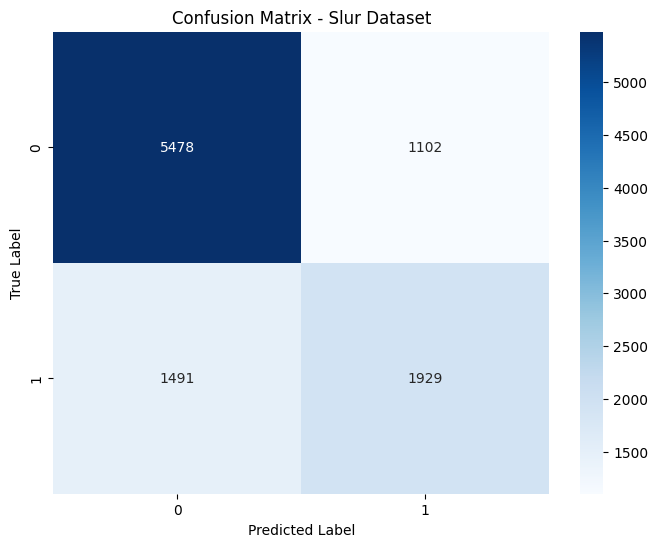

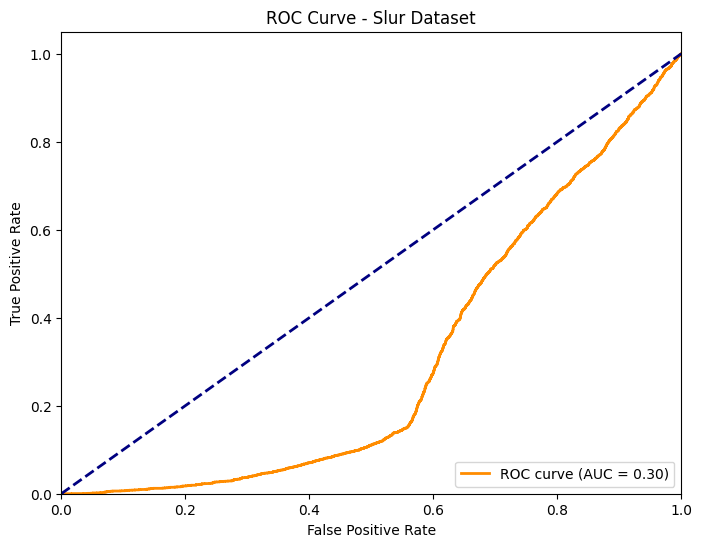

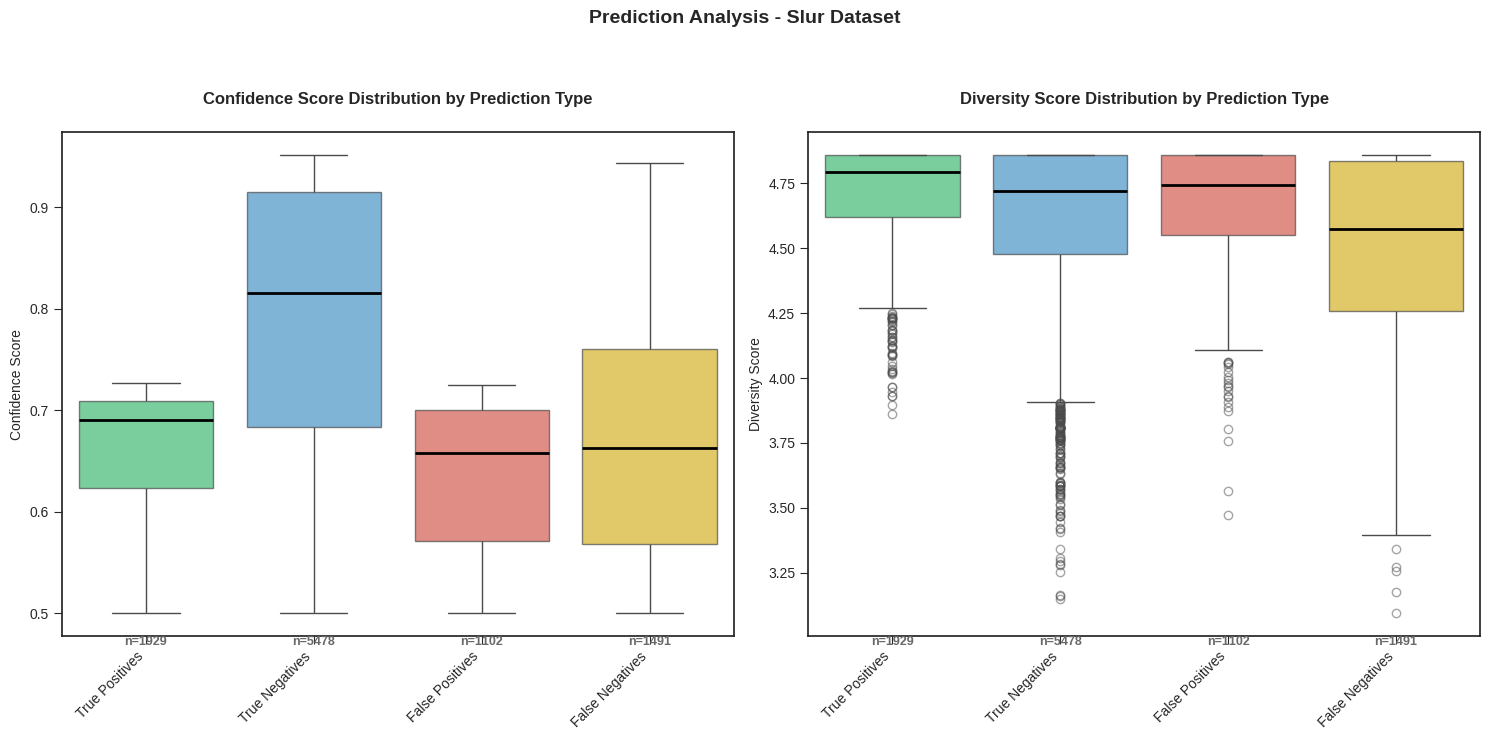


Evaluation Results for Slur Dataset dataset:
--------------------------------------------------
accuracy: 0.7407


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from typing import Dict, List, Tuple, Optional

def analyze_predictions(
    true_labels: np.ndarray,
    predicted_labels: np.ndarray,
    confidence_scores: np.ndarray,
    diversity_scores: np.ndarray,
    save_path: str,
    dataset_name: str
) -> Dict[str, np.ndarray]:
    """
    Analyze different types of predictions with enhanced visualization.
    """
    # Set the style
    plt.style.use('seaborn-v0_8-ticks')

    # Custom color scheme
    colors = {
        'True Positives': '#2ecc71',    # Green for correct positive predictions
        'True Negatives': '#3498db',    # Blue for correct negative predictions
        'False Positives': '#e74c3c',   # Red for false positives
        'False Negatives': '#f1c40f'    # Yellow for false negatives
    }

    # Identify different types of predictions
    prediction_types = {
        'True Positives': (true_labels == 1) & (predicted_labels == 1),
        'True Negatives': (true_labels == 0) & (predicted_labels == 0),
        'False Positives': (true_labels == 0) & (predicted_labels == 1),
        'False Negatives': (true_labels == 1) & (predicted_labels == 0)
    }

    # Create figure with larger size and higher DPI
    plt.figure(figsize=(15, 7), dpi=100)

    # Prepare data for confidence scores
    confidence_data = []
    confidence_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            confidence_data.append(confidence_scores[mask])
            confidence_labels.extend([pred_type] * sum(mask))

    # Create DataFrame for confidence scores
    import pandas as pd
    df_confidence = pd.DataFrame({
        'Prediction Type': confidence_labels,
        'Confidence Score': np.concatenate(confidence_data)
    })

    # Plot confidence scores with enhanced styling
    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_confidence,
        x='Prediction Type',
        y='Confidence Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,  # Show outlier points
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2},
        whis=1.5  # Set whisker length to 1.5 IQR
    )

    plt.xticks(rotation=45, ha='right')
    plt.title('Confidence Score Distribution by Prediction Type',
              pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Confidence Score', fontsize=10)
    plt.xlabel('')

    # Prepare data for diversity scores
    diversity_data = []
    diversity_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            diversity_data.append(diversity_scores[mask])
            diversity_labels.extend([pred_type] * sum(mask))

    # Create DataFrame for diversity scores
    df_diversity = pd.DataFrame({
        'Prediction Type': diversity_labels,
        'Diversity Score': np.concatenate(diversity_data)
    })

    # Plot diversity scores with enhanced styling
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_diversity,
        x='Prediction Type',
        y='Diversity Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2},
        whis=1.5
    )

    plt.xticks(rotation=45, ha='right')
    plt.title('Diversity Score Distribution by Prediction Type',
              pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Diversity Score', fontsize=10)
    plt.xlabel('')

    # Add a super title for the entire figure
    plt.suptitle(f'Prediction Analysis - {dataset_name}',
                 y=1.05, fontsize=14, fontweight='bold')

    # Adjust layout and add grid
    plt.tight_layout()

    # Add prediction counts in the plot
    for i, (ax, metric) in enumerate([('Confidence', confidence_data),
                                    ('Diversity', diversity_data)]):
        plt.subplot(1, 2, i+1)
        ylim = plt.gca().get_ylim()
        for j, (pred_type, data) in enumerate(zip(prediction_types.keys(), metric)):
            count = len(data)
            plt.text(j, ylim[0], f'n={count}',
                    ha='center', va='top', fontsize=9,
                    color='dimgray', fontweight='bold')

    # Save the figure
    plt.show()
    plt.savefig(f'{save_path}/prediction_analysis_{dataset_name}.png',
                bbox_inches='tight', dpi=300)
    plt.close()

    return prediction_types

def evaluate_and_visualize(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    save_path: str = "evaluation_results/",
    dataset_name: str = "test"
) -> Tuple[List[int], Dict[str, float], Optional[List[np.ndarray]]]:
    """
    Evaluate model and create visualizations for analysis.

    Args:
        model: The trained model
        data_loader: DataLoader for the evaluation dataset
        criterion: Loss function
        save_path: Directory to save visualizations
        dataset_name: Name of the dataset for plot titles

    Returns:
        Tuple of predictions, metrics, and attention weights
    """
    # Create save directory if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)

    # Get predictions and metrics
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidence_scores = []
    all_diversity_scores = []
    attention_weights = []

    with torch.no_grad():
        for batch in data_loader:
            # Assuming the same batch structure as in the original evaluate function
            attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

            # Move inputs to device
            device = next(model.parameters()).device
            inputs = {
                'input_nodes': node_features.to(device),
                'input_edges': in_degree.to(device),
                'attn_bias': attn_bias.to(device),
                'in_degree': in_degree.to(device),
                'out_degree': out_degree.to(device),
                'spatial_pos': spatial_pos.to(device),
                'attn_edge_type': attn_edge_type.to(device)
            }

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits

            # Get predictions and confidence scores
            if logits.dim() == 1:
                logits = logits.unsqueeze(-1)
                logits = torch.cat([1 - logits, logits], dim=1)

            probabilities = torch.softmax(logits, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence_scores.extend(confidence.cpu().numpy())
            all_diversity_scores.extend(outputs.diversity_scores.mean(dim=1).cpu().numpy())

            if hasattr(outputs, 'attention_weights') and outputs.attention_weights is not None:
                attention_weights.append(outputs.attention_weights.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidence_scores = np.array(all_confidence_scores)
    all_diversity_scores = np.array(all_diversity_scores)

    # Calculate metrics
    metrics = {
        'accuracy': np.mean(all_predictions == all_labels),
        'diversity_scores': all_diversity_scores,
    }

    # Create visualizations
    # 1. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    plt.savefig(f'{save_path}/confusion_matrix_{dataset_name}.png')
    plt.close()

    # 2. ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(all_labels, all_confidence_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(f'{save_path}/roc_curve_{dataset_name}.png')
    plt.close()

    # 3. Analyze predictions with boxplots
    prediction_types = analyze_predictions(
        all_labels,
        all_predictions,
        all_confidence_scores,
        all_diversity_scores,
        save_path,
        dataset_name
    )

    # Add prediction type metrics
    for pred_type, mask in prediction_types.items():
        metrics[f'{pred_type.lower().replace(" ", "_")}_count'] = np.sum(mask)
        if np.any(mask):
            metrics[f'{pred_type.lower().replace(" ", "_")}_avg_confidence'] = np.mean(all_confidence_scores[mask])
            metrics[f'{pred_type.lower().replace(" ", "_")}_avg_diversity'] = np.mean(all_diversity_scores[mask])

    # Print detailed metrics
    print(f"\nEvaluation Results for {dataset_name} dataset:")
    print("-" * 50)
    for metric_name, value in metrics.items():
        if isinstance(value, (float, int)):
            print(f"{metric_name}: {value:.4f}")

    return all_predictions, metrics, attention_weights

predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Slur Dataset"
)

In [74]:
val_predictions, val_metrics, _ = evaluate(model, val_data_loader, criterion)

In [75]:
# Generate classification report
report = classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.58      0.97      0.72       103
     Class 1       0.25      0.01      0.03        74

    accuracy                           0.57       177
   macro avg       0.41      0.49      0.38       177
weighted avg       0.44      0.57      0.43       177



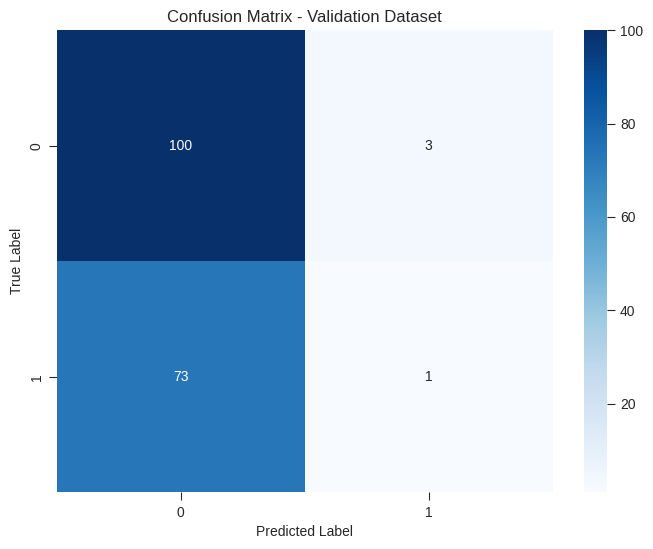

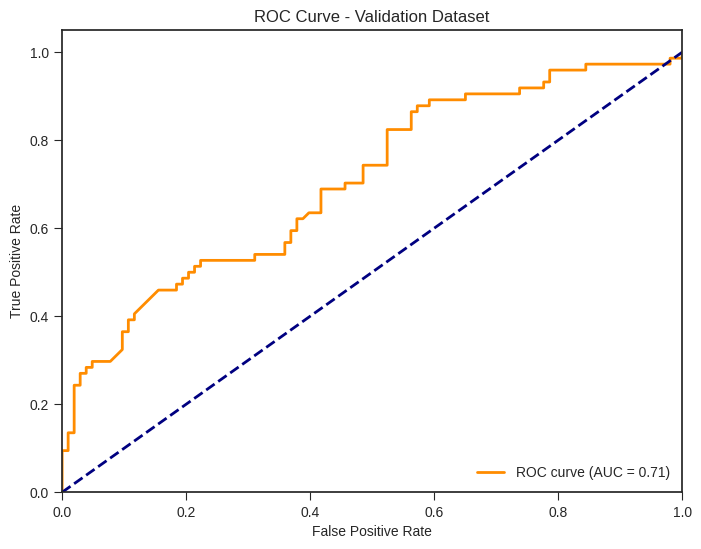

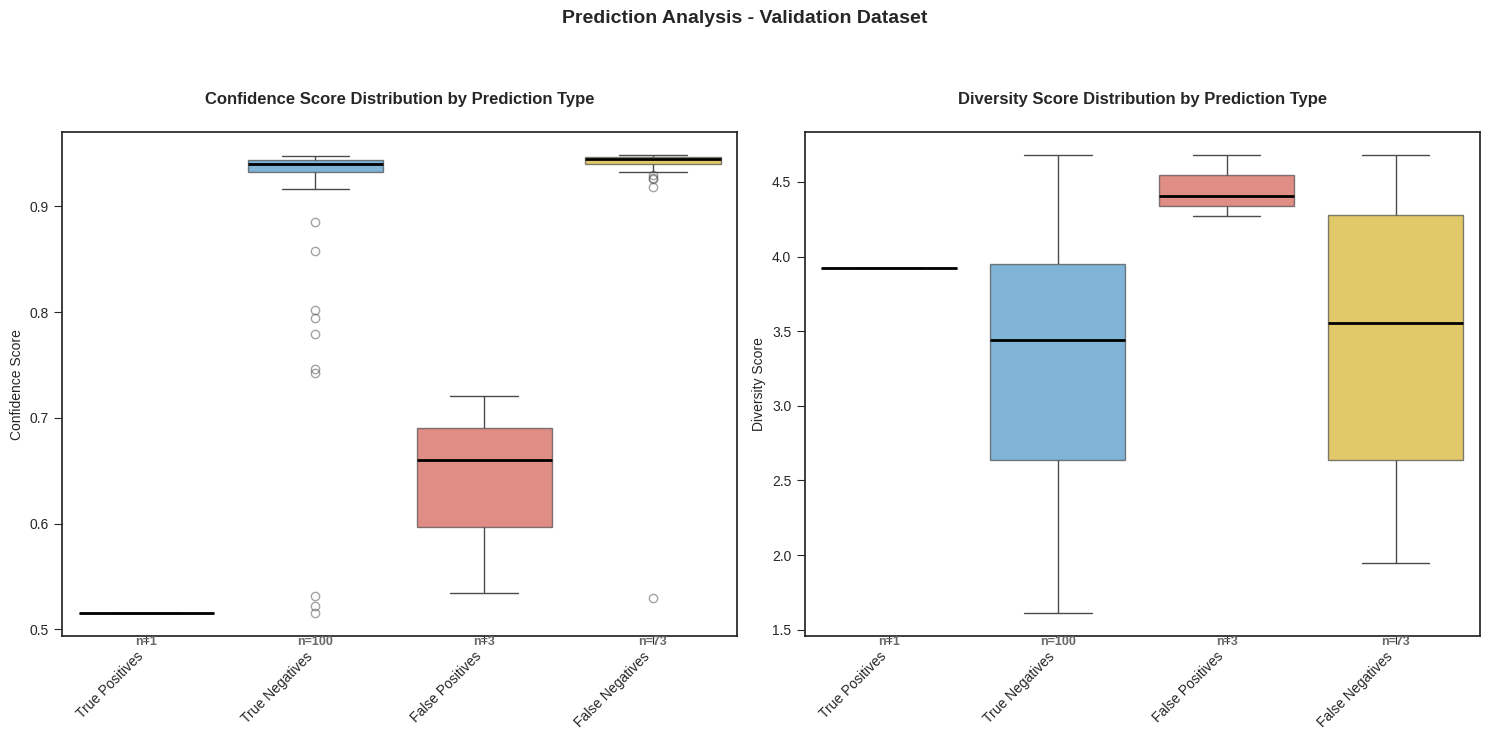


Evaluation Results for Validation Dataset dataset:
--------------------------------------------------
accuracy: 0.5706


In [76]:
predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    val_data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Validation Dataset"
)

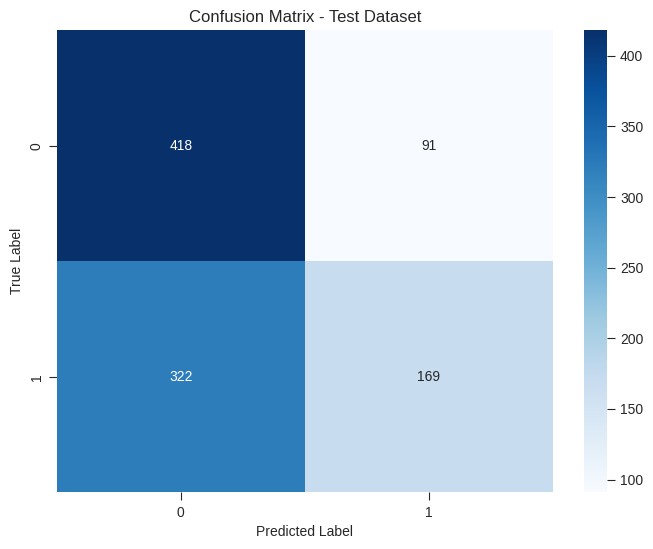

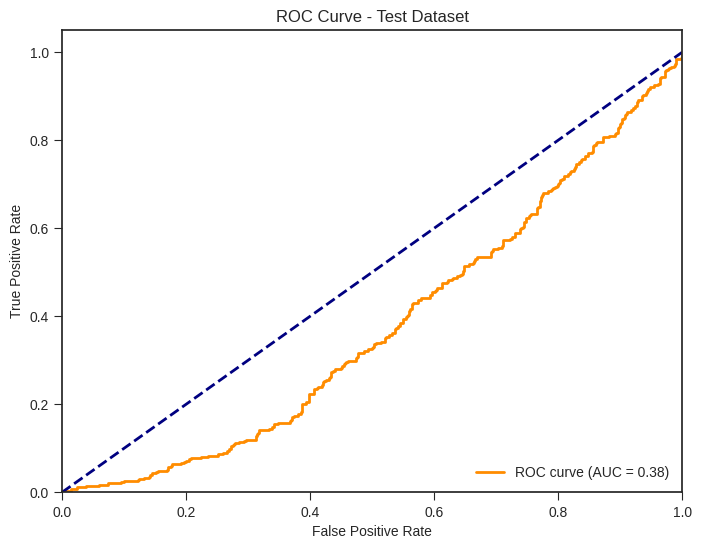

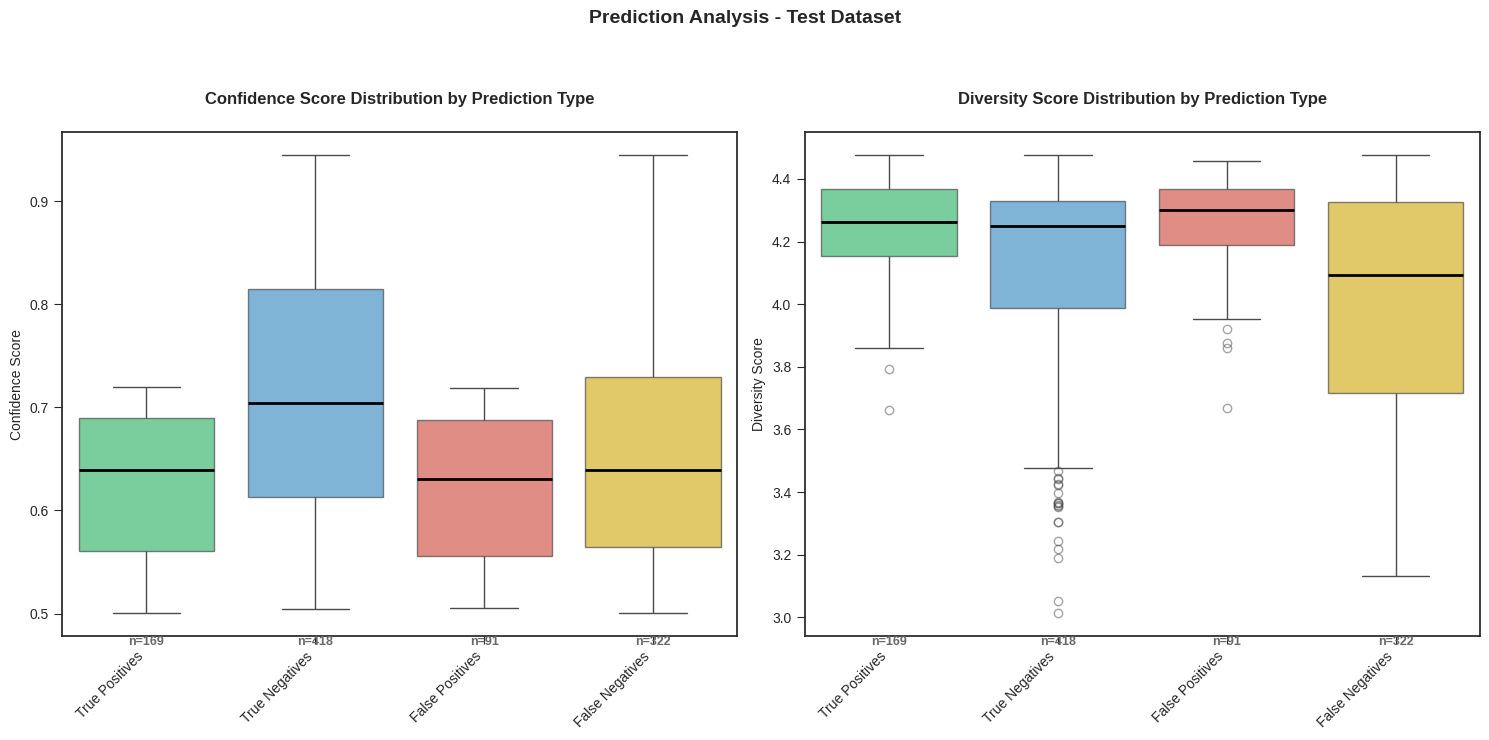


Evaluation Results for Test Dataset dataset:
--------------------------------------------------
accuracy: 0.5870


In [77]:
predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    slur_data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Test Dataset"
)

In [78]:
val_hrg = pd.DataFrame({'Text': val_df['text'],
                   'Og labels': val_labels,
                   'Predictions': val_predictions})

val_hrg.to_csv('div_graphormer_val.csv', index=False)

In [79]:
break

SyntaxError: 'break' outside loop (<ipython-input-79-6aaf1f276005>, line 1)

In [ ]:
break

## MultiGraphormer

In [80]:
from torch.nn.utils import clip_grad_norm_
from transformers import AdamW, GraphormerConfig, GraphormerForGraphClassification
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [81]:
sarc_normalized_embeddings = normalize_embeddings(sarc_embeddings)
num_bins = 256
sarc_quantized_embeddings = quantize_embeddings(sarc_normalized_embeddings, num_bins=num_bins)

In [82]:
torch.cuda.empty_cache()
gc.collect()

36694

In [83]:
graphs2, labels2 = create_dgl_graphs(df_posts3, sarc_input_ids, sarc_attention_masks, sarc_quantized_embeddings, 'text', 'label')
sarc_dataset = GraphDataset(graphs2, labels2)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [84]:
from sklearn.model_selection import train_test_split

sarcasm_train_dataset, sarcasm_val_dataset = train_test_split(sarc_dataset)
sarcasm_train_loader = DataLoader(sarcasm_train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
sarcasm_val_loader = DataLoader(sarcasm_val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [85]:
hate_speech_train_loader = data_loader
hate_speech_val_loader = slur_data_loader

In [86]:
torch.cuda.empty_cache()
gc.collect()

30763

In [87]:
class DiversityAwareClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size

        # Graph-level prediction head
        self.graph_prediction_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.hidden_size, 2)
        )

        # Diversity scoring mechanism
        self.diversity_score = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size // 2, 1)
        )

        # Attention mechanism for diversity
        self.attention = nn.MultiheadAttention(
            embed_dim=config.hidden_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )

    def forward(self, node_embeddings, graph_embedding):
        # Calculate attention weights
        attn_output, attention_weights = self.attention(
            node_embeddings,
            node_embeddings,
            node_embeddings
        )

        # Calculate diversity scores
        diversity_scores = self.diversity_score(attn_output).squeeze(-1)

        # Get graph-level predictions
        graph_predictions = self.graph_prediction_head(graph_embedding)

        return graph_predictions, diversity_scores, attention_weights

class EnhancedMultiTaskGraphormer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.graphormer = GraphormerForGraphClassification(config)

        # Node embedding processing
        self.node_embedding_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(0.2)

        # Enhanced pooling with attention
        self.pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, config.hidden_size)),
            nn.Dropout(0.2)
        )

        # Shared representation layer
        self.shared_representation = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2)
        )

        # Task-specific diversity-aware classifiers
        self.hate_speech_classifier = DiversityAwareClassifier(config)
        self.sarcasm_classifier = DiversityAwareClassifier(config)

    def forward(
        self,
        input_nodes=None,
        input_edges=None,
        attn_bias=None,
        in_degree=None,
        out_degree=None,
        spatial_pos=None,
        attn_edge_type=None,
        return_dict=True,
    ):
        # Get base Graphormer outputs
        outputs = self.graphormer(
            input_nodes=input_nodes,
            input_edges=input_edges,
            attn_bias=attn_bias,
            in_degree=in_degree,
            out_degree=out_degree,
            spatial_pos=spatial_pos,
            attn_edge_type=attn_edge_type,
            return_dict=True,
            output_hidden_states=True,
        )

        last_hidden_state = outputs.hidden_states[-1].transpose(0, 1)

        # Process node embeddings
        node_embeddings = self.node_embedding_proj(last_hidden_state)
        node_embeddings = self.layer_norm(node_embeddings)
        node_embeddings = self.dropout(node_embeddings)

        # Create graph-level embedding
        graph_embedding = torch.mean(node_embeddings, dim=1)

        # Get shared representation
        shared_rep = self.shared_representation(graph_embedding)

        # Task-specific predictions with diversity awareness
        hate_preds, hate_div_scores, hate_attn = self.hate_speech_classifier(
            node_embeddings, shared_rep
        )
        sarcasm_preds, sarcasm_div_scores, sarcasm_attn = self.sarcasm_classifier(
            node_embeddings, shared_rep
        )

        if not return_dict:
            return (
                hate_preds,
                sarcasm_preds,
                hate_div_scores,
                sarcasm_div_scores,
                hate_attn,
                sarcasm_attn
            )

        return {
            'hate_speech_logits': hate_preds,
            'sarcasm_logits': sarcasm_preds,
            'hate_diversity_scores': hate_div_scores,
            'sarcasm_diversity_scores': sarcasm_div_scores,
            'hate_attention_weights': hate_attn,
            'sarcasm_attention_weights': sarcasm_attn,
            'hidden_states': outputs.hidden_states,
            'attentions': outputs.attentions
        }

def create_model_and_optimizer(config, device, training_args):
    model = EnhancedMultiTaskGraphormer(config).to(device)

    # Separate parameter groups with different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': training_args['weight_decay']
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=training_args['learning_rate']
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-7
    )

    return model, optimizer, scheduler

def prepare_batch(batch):
    """Prepare batch data for model input"""
    attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, _ = batch

    return {
        'input_nodes': node_features.to(device),
        'input_edges': in_degree.to(device),
        'attn_bias': attn_bias.to(device),
        'in_degree': in_degree.to(device),
        'out_degree': out_degree.to(device),
        'spatial_pos': spatial_pos.to(device),
        'attn_edge_type': attn_edge_type.to(device)
    }

def compute_loss(logits, labels):
    """Compute cross entropy loss with label smoothing"""
    return torch.nn.CrossEntropyLoss(
        label_smoothing=0.1
    )(logits, labels)

def calculate_metrics(labels, predictions):
    """Calculate classification metrics"""
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision_recall': precision_recall_fscore_support(
            labels, predictions, average='weighted'
        )[:2]
    }

# Optimized configuration
config = GraphormerConfig(
    num_classes=2,
    hidden_size=768,
    num_attention_heads=8,
    num_hidden_layers=6,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    edge_type="multi",
    num_edge_types=2,
    multi_hop_max_dist=4,
    ignore_mismatched_sizes=True,
    use_checkpoint=True,
    max_position_embeddings=512,
    layer_norm_eps=1e-5
)

# Training arguments
training_args = {
    'learning_rate': 1e-6,
    'weight_decay': 0.01,
    'warmup_steps': 100,
    'gradient_accumulation_steps': 4,
    'max_grad_norm': 0.5,
    'batch_size': 16
}

In [88]:
#past evaluate

In [89]:
def train_epoch(model, hate_speech_loader, sarcasm_loader, optimizer, criterion, scaler, training_args):
    model.train()
    total_hate_loss = 0.0
    total_sarcasm_loss = 0.0
    metrics = {
        'hate_speech': {'preds': [], 'labels': [], 'diversity_gaps': []},
        'sarcasm': {'preds': [], 'labels': [], 'diversity_gaps': []}
    }

    hate_iter = iter(hate_speech_loader)
    sarcasm_iter = iter(sarcasm_loader)

    progress_bar = tqdm(range(max(len(hate_speech_loader), len(sarcasm_loader))), desc="Training")

    for _ in progress_bar:
        # Get batches
        try:
            hate_batch = next(hate_iter)
        except StopIteration:
            hate_iter = iter(hate_speech_loader)
            hate_batch = next(hate_iter)

        try:
            sarcasm_batch = next(sarcasm_iter)
        except StopIteration:
            sarcasm_iter = iter(sarcasm_loader)
            sarcasm_batch = next(sarcasm_iter)

        # Process batches
        hate_inputs = prepare_batch(hate_batch)
        sarcasm_inputs = prepare_batch(sarcasm_batch)

        hate_labels = hate_batch[-1].to(hate_inputs['input_nodes'].device)
        sarcasm_labels = sarcasm_batch[-1].to(sarcasm_inputs['input_nodes'].device)

        # Forward pass with mixed precision
        with autocast():
            hate_outputs = model(**hate_inputs)

            # Extract node embeddings from the last hidden state
            hate_node_embeddings = hate_outputs['hidden_states'][-1].transpose(0, 1)

            # Get diversity scores directly from node embeddings if not provided by model
            hate_diversity_scores = torch.std(hate_node_embeddings, dim=2)  # [batch_size, seq_len]

            # Compute losses for hate speech task
            hate_loss, hate_ce, hate_div = criterion(
                hate_outputs['logits'] if 'logits' in hate_outputs else hate_outputs['hate_speech_logits'],
                hate_labels,
                hate_node_embeddings,
                hate_diversity_scores
            )

            # Process sarcasm task
            sarcasm_outputs = model(**sarcasm_inputs)
            sarcasm_node_embeddings = sarcasm_outputs['hidden_states'][-1].transpose(0, 1)
            sarcasm_diversity_scores = torch.std(sarcasm_node_embeddings, dim=2)

            sarcasm_loss, sarcasm_ce, sarcasm_div = criterion(
                sarcasm_outputs['logits'] if 'logits' in sarcasm_outputs else sarcasm_outputs['sarcasm_logits'],
                sarcasm_labels,
                sarcasm_node_embeddings,
                sarcasm_diversity_scores
            )

            total_loss = hate_loss + sarcasm_loss

        # Backward pass with gradient scaling
        scaler.scale(total_loss).backward()

        if (_ + 1) % training_args['gradient_accumulation_steps'] == 0:
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), training_args['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Update metrics
        total_hate_loss += hate_loss.item()
        total_sarcasm_loss += sarcasm_loss.item()

        # Track predictions and diversity metrics
        for task, outputs, labels, div_scores in [
            ('hate_speech', hate_outputs, hate_labels, hate_diversity_scores),
            ('sarcasm', sarcasm_outputs, sarcasm_labels, sarcasm_diversity_scores)
        ]:
            logits = outputs['logits'] if 'logits' in outputs else outputs[f'{task}_logits']

            preds = torch.argmax(logits, dim=1)
            metrics[task]['preds'].extend(preds.cpu().numpy())
            metrics[task]['labels'].extend(labels.cpu().numpy())

            # Calculate diversity gap between positive and negative classes
            pos_mask = labels == 1
            neg_mask = labels == 0

            if torch.any(pos_mask) and torch.any(neg_mask):
                pos_div = div_scores[pos_mask].mean()
                neg_div = div_scores[neg_mask].mean()
                div_gap = torch.abs(pos_div - neg_div)
                metrics[task]['diversity_gaps'].append(div_gap.item())

        progress_bar.set_postfix({
            'hate_loss': hate_loss.item(),
            'sarcasm_loss': sarcasm_loss.item()
        })

    # Calculate final metrics
    results = {}
    for task in ['hate_speech', 'sarcasm']:
        results[task] = {
            'loss': total_hate_loss / len(hate_speech_loader) if task == 'hate_speech'
                   else total_sarcasm_loss / len(sarcasm_loader),
            'f1': f1_score(
                metrics[task]['labels'],
                metrics[task]['preds'],
                average='weighted'
            ),
            'diversity_gap': float(np.mean(metrics[task]['diversity_gaps']))
                if metrics[task]['diversity_gaps'] else 0.0
        }

    return results

In [90]:
def evaluate(model, eval_loader, criterion, task):
    """
    Evaluate model on given data loader for specified task

    Args:
        model: The model to evaluate
        eval_loader: DataLoader containing evaluation data
        criterion: Loss criterion that handles both CE and diversity losses
        task: Either 'hate_speech' or 'sarcasm'
    """
    model.eval()
    total_loss = 0.0
    metrics = {
        'preds': [],
        'labels': [],
        'diversity_gaps': []
    }

    with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"Evaluating {task}"):
            # Prepare inputs
            inputs = prepare_batch(batch)
            labels = batch[-1].to(inputs['input_nodes'].device)

            # Forward pass
            outputs = model(**inputs)

            # Extract embeddings and compute diversity scores
            node_embeddings = outputs['hidden_states'][-1].transpose(0, 1)
            diversity_scores = torch.std(node_embeddings, dim=2)  # [batch_size, seq_len]

            # Get appropriate logits based on task
            logits = outputs['logits'] if 'logits' in outputs else outputs[f'{task}_logits']

            # Compute loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                node_embeddings,
                diversity_scores
            )

            total_loss += loss.item()

            # Track predictions
            preds = torch.argmax(logits, dim=1)
            metrics['preds'].extend(preds.cpu().numpy())
            metrics['labels'].extend(labels.cpu().numpy())

            # Calculate diversity gap between positive and negative classes
            pos_mask = labels == 1
            neg_mask = labels == 0

            if torch.any(pos_mask) and torch.any(neg_mask):
                pos_div = diversity_scores[pos_mask].mean()
                neg_div = diversity_scores[neg_mask].mean()
                div_gap = torch.abs(pos_div - neg_div)
                metrics['diversity_gaps'].append(div_gap.item())

    # Calculate final metrics
    results = {
        'loss': total_loss / len(eval_loader),
        'f1': f1_score(
            metrics['labels'],
            metrics['preds'],
            average='weighted'
        ),
        'accuracy': accuracy_score(metrics['labels'], metrics['preds']),
        'precision_recall': precision_recall_fscore_support(
            metrics['labels'],
            metrics['preds'],
            average='weighted'
        )[:2],
        'diversity_gap': float(np.mean(metrics['diversity_gaps']))
            if metrics['diversity_gaps'] else 0.0
    }

    return results

In [91]:
def train_model(config, training_args, model, dataloaders, device):
    """
    Main training loop for multi-task learning of hate speech and sarcasm detection
    """
    # Ensure model is on correct device
    model = model.to(device)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=training_args['learning_rate'],
        weight_decay=training_args['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=training_args['scheduler_patience'],
        verbose=True
    )

    # Initialize loss criterion
    criterion = DiversityLoss(
        num_classes=2,
        alpha=training_args['ce_loss_weight'],
        beta=training_args['diversity_loss_weight']
    )

    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler() if device.type == 'cuda' else None

    # Training tracking
    best_val_f1 = 0
    best_model = None
    early_stopping_counter = 0

    # Create checkpoint directory
    checkpoint_dir = os.path.join(training_args['output_dir'],
                                f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Main training loop
    for epoch in range(training_args['num_epochs']):
        print(f"\nEpoch {epoch + 1}/{training_args['num_epochs']}")

        # Training phase
        train_metrics = train_epoch(
            model=model,
            hate_speech_loader=dataloaders['hate_speech_train'],
            sarcasm_loader=dataloaders['sarcasm_train'],
            optimizer=optimizer,
            criterion=criterion,
            scaler=scaler,
            training_args=training_args
        )

        # Validation phase
        val_metrics = {}
        for task in ['hate_speech', 'sarcasm']:
            val_metrics[task] = evaluate(
                model=model,
                eval_loader=dataloaders[f'{task}_val'],
                criterion=criterion,
                task=task
            )

        # Print detailed metrics
        print("\nTraining Metrics:")
        for task in ['hate_speech', 'sarcasm']:
            print(f"  {task.title()}:")
            for metric, value in train_metrics[task].items():
                if isinstance(value, float):
                    print(f"    {metric}: {value:.4f}")

        print("\nValidation Metrics:")
        for task in ['hate_speech', 'sarcasm']:
            print(f"  {task.title()}:")
            for metric, value in val_metrics[task].items():
                if isinstance(value, float):
                    print(f"    {metric}: {value:.4f}")

        # Calculate average validation F1 for model selection
        avg_val_f1 = (val_metrics['hate_speech']['f1'] +
                     val_metrics['sarcasm']['f1']) / 2

        # Model checkpointing
        if avg_val_f1 > best_val_f1:
            best_val_f1 = avg_val_f1
            early_stopping_counter = 0

            # Save best model
            best_model = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_metrics': val_metrics,
                'train_metrics': train_metrics,
                'config': config,
                'training_args': training_args
            }

            torch.save(
                best_model,
                os.path.join(checkpoint_dir, 'best_model.pt')
            )
        else:
            early_stopping_counter += 1

        # Learning rate scheduling
        avg_val_loss = (val_metrics['hate_speech']['loss'] +
                       val_metrics['sarcasm']['loss']) / 2
        scheduler.step(avg_val_loss)


    return best_model

In [92]:
default_training_args = {
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'scheduler_patience': 2,
    'early_stopping_patience': 3,
    'min_epochs': 5,
    'save_every_n_epochs': 5,
    'gradient_accumulation_steps': 1,
    'max_grad_norm': 1.0,
    'ce_loss_weight': 1.0,
    'diversity_loss_weight': 0.1,
    'output_dir': 'checkpoints'
}

In [93]:
from datetime import datetime

In [94]:
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, scheduler = create_model_and_optimizer(config, device, training_args)
criterion = DiversityLoss(num_classes=2, alpha=1.0, beta=0.1)
num_epochs = 10

dataloaders = {
    'hate_speech_train': hate_speech_train_loader,
    'sarcasm_train': sarcasm_train_loader,
    'hate_speech_val': hate_speech_val_loader,
    'sarcasm_val': sarcasm_val_loader
}

model = model.to(device)

model = train_model(
    config=config,
    training_args=default_training_args,
    model=model,
    dataloaders=dataloaders,
    device=device
)


Epoch 1/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 16.82it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5376
    f1: 0.7148
    diversity_gap: 0.0005
  Sarcasm:
    loss: 1.3338
    f1: 0.5066
    diversity_gap: 0.0002

Validation Metrics:
  Hate_Speech:
    loss: 0.6717
    f1: 0.6060
    accuracy: 0.6060
    diversity_gap: 0.0004
  Sarcasm:
    loss: 0.6951
    f1: 0.3524
    accuracy: 0.4810
    diversity_gap: 0.0003

Epoch 2/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.17it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5295
    f1: 0.7309
    diversity_gap: 0.0016
  Sarcasm:
    loss: 1.3297
    f1: 0.5119
    diversity_gap: 0.0005

Validation Metrics:
  Hate_Speech:
    loss: 0.6638
    f1: 0.6251
    accuracy: 0.6260
    diversity_gap: 0.0012
  Sarcasm:
    loss: 0.6906
    f1: 0.5219
    accuracy: 0.5363
    diversity_gap: 0.0009

Epoch 3/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.18it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5315
    f1: 0.7287
    diversity_gap: 0.0028
  Sarcasm:
    loss: 1.3273
    f1: 0.5240
    diversity_gap: 0.0009

Validation Metrics:
  Hate_Speech:
    loss: 0.6677
    f1: 0.6269
    accuracy: 0.6270
    diversity_gap: 0.0018
  Sarcasm:
    loss: 0.6923
    f1: 0.4965
    accuracy: 0.5133
    diversity_gap: 0.0013

Epoch 4/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 16.98it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5243
    f1: 0.7306
    diversity_gap: 0.0041
  Sarcasm:
    loss: 1.3287
    f1: 0.5178
    diversity_gap: 0.0015

Validation Metrics:
  Hate_Speech:
    loss: 0.6603
    f1: 0.6349
    accuracy: 0.6350
    diversity_gap: 0.0027
  Sarcasm:
    loss: 0.6916
    f1: 0.5165
    accuracy: 0.5167
    diversity_gap: 0.0020

Epoch 5/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.05it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5228
    f1: 0.7366
    diversity_gap: 0.0060
  Sarcasm:
    loss: 1.3272
    f1: 0.5208
    diversity_gap: 0.0020

Validation Metrics:
  Hate_Speech:
    loss: 0.6667
    f1: 0.6114
    accuracy: 0.6120
    diversity_gap: 0.0033
  Sarcasm:
    loss: 0.6935
    f1: 0.4845
    accuracy: 0.5081
    diversity_gap: 0.0025

Epoch 6/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.06it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5234
    f1: 0.7323
    diversity_gap: 0.0074
  Sarcasm:
    loss: 1.3281
    f1: 0.5188
    diversity_gap: 0.0025

Validation Metrics:
  Hate_Speech:
    loss: 0.6604
    f1: 0.6314
    accuracy: 0.6320
    diversity_gap: 0.0047
  Sarcasm:
    loss: 0.6924
    f1: 0.5164
    accuracy: 0.5173
    diversity_gap: 0.0034

Epoch 7/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.05it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5211
    f1: 0.7333
    diversity_gap: 0.0094
  Sarcasm:
    loss: 1.3262
    f1: 0.5235
    diversity_gap: 0.0031

Validation Metrics:
  Hate_Speech:
    loss: 0.6596
    f1: 0.6197
    accuracy: 0.6200
    diversity_gap: 0.0060
  Sarcasm:
    loss: 0.6933
    f1: 0.5396
    accuracy: 0.5438
    diversity_gap: 0.0040

Epoch 8/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.02it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5136
    f1: 0.7383
    diversity_gap: 0.0108
  Sarcasm:
    loss: 1.3240
    f1: 0.5290
    diversity_gap: 0.0037

Validation Metrics:
  Hate_Speech:
    loss: 0.6597
    f1: 0.6270
    accuracy: 0.6270
    diversity_gap: 0.0057
  Sarcasm:
    loss: 0.6929
    f1: 0.5091
    accuracy: 0.5167
    diversity_gap: 0.0040

Epoch 9/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.17it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5107
    f1: 0.7372
    diversity_gap: 0.0112
  Sarcasm:
    loss: 1.3216
    f1: 0.5295
    diversity_gap: 0.0036

Validation Metrics:
  Hate_Speech:
    loss: 0.6633
    f1: 0.6197
    accuracy: 0.6200
    diversity_gap: 0.0059
  Sarcasm:
    loss: 0.6937
    f1: 0.5039
    accuracy: 0.5127
    diversity_gap: 0.0041

Epoch 10/10


Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.08it/s]



Training Metrics:
  Hate_Speech:
    loss: 0.5073
    f1: 0.7397
    diversity_gap: 0.0117
  Sarcasm:
    loss: 1.3226
    f1: 0.5278
    diversity_gap: 0.0040

Validation Metrics:
  Hate_Speech:
    loss: 0.6633
    f1: 0.6235
    accuracy: 0.6240
    diversity_gap: 0.0062
  Sarcasm:
    loss: 0.6948
    f1: 0.4958
    accuracy: 0.5092
    diversity_gap: 0.0043


In [99]:
model['model_state_dict']

OrderedDict([('graphormer.encoder.graph_encoder.graph_node_feature.atom_encoder.weight',
              tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
                        0.0000e+00,  0.0000e+00],
                      [-9.4451e-03,  1.9313e-02,  8.0361e-05,  ...,  1.6048e-03,
                       -1.3957e-02,  5.8356e-02],
                      [ 3.0264e-02,  4.2197e-03,  2.4248e-03,  ..., -2.2246e-02,
                       -6.8215e-03, -5.7969e-03],
                      ...,
                      [-2.1014e-03,  1.1031e-02,  1.3811e-02,  ...,  3.6284e-02,
                       -1.4257e-02, -1.0285e-02],
                      [-2.0082e-03, -8.1939e-03, -1.0329e-02,  ...,  7.6591e-03,
                        2.2711e-03,  2.1520e-02],
                      [-1.5968e-02,  7.5917e-03, -1.2035e-02,  ..., -1.6612e-02,
                       -2.3318e-02, -2.1085e-02]], device='cuda:0')),
             ('graphormer.encoder.graph_encoder.graph_node_feature.in_degree_e

In [100]:
torch.save(model['model_state_dict'], "div_multigraphormmer.pt")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

def evaluate_and_visualize(
    model: torch.nn.Module,
    eval_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    task: str,
    save_path: str = "evaluation_results/",
    dataset_name: str = "test"
) -> Tuple[np.ndarray, Dict[str, float], List[np.ndarray]]:
    """
    Evaluate model and create visualizations for analysis.

    Args:
        model: The trained model
        eval_loader: DataLoader containing evaluation data
        criterion: Loss criterion that handles both CE and diversity losses
        task: Either 'hate_speech' or 'sarcasm'
        save_path: Directory to save visualizations
        dataset_name: Name of the dataset for plot titles

    Returns:
        Tuple of predictions, metrics, and diversity scores
    """
    # Create save directory if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    all_confidence_scores = []
    all_diversity_scores = []
    diversity_gaps = []

    with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"Evaluating {task}"):
            # Prepare inputs
            inputs = prepare_batch(batch)
            labels = batch[-1].to(inputs['input_nodes'].device)

            # Forward pass
            outputs = model(**inputs)

            # Extract embeddings and compute diversity scores
            node_embeddings = outputs['hidden_states'][-1].transpose(0, 1)
            diversity_scores = torch.std(node_embeddings, dim=2)  # [batch_size, seq_len]

            # Get appropriate logits based on task
            logits = outputs['logits'] if 'logits' in outputs else outputs[f'{task}_logits']

            # Compute loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                node_embeddings,
                diversity_scores
            )

            total_loss += loss.item()

            # Get predictions and confidence scores
            probabilities = torch.softmax(logits, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence_scores.extend(confidence.cpu().numpy())
            all_diversity_scores.extend(diversity_scores.mean(dim=1).cpu().numpy())

            # Calculate diversity gap between positive and negative classes
            pos_mask = labels == 1
            neg_mask = labels == 0

            if torch.any(pos_mask) and torch.any(neg_mask):
                pos_div = diversity_scores[pos_mask].mean()
                neg_div = diversity_scores[neg_mask].mean()
                div_gap = torch.abs(pos_div - neg_div)
                diversity_gaps.append(div_gap.item())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidence_scores = np.array(all_confidence_scores)
    all_diversity_scores = np.array(all_diversity_scores)

    # Calculate metrics
    metrics = {
        'loss': total_loss / len(eval_loader),
        'accuracy': accuracy_score(all_labels, all_predictions),
        'f1': f1_score(all_labels, all_predictions, average='weighted'),
        'diversity_gap': float(np.mean(diversity_gaps)) if diversity_gaps else 0.0
    }

    precision, recall = precision_recall_fscore_support(
        all_labels,
        all_predictions,
        average='weighted'
    )[:2]
    metrics['precision'] = precision
    metrics['recall'] = recall

    # Create visualizations with custom color scheme
    colors = {
        'True Positives': '#2ecc71',
        'True Negatives': '#3498db',
        'False Positives': '#e74c3c',
        'False Negatives': '#f1c40f'
    }

    # 1. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name} ({task})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{save_path}/confusion_matrix_{task}_{dataset_name}.png')
    plt.show()
    plt.close()

    # 2. ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(all_labels, all_confidence_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name} ({task})')
    plt.legend(loc="lower right")
    plt.savefig(f'{save_path}/roc_curve_{task}_{dataset_name}.png')
    plt.show()
    plt.close()

    # 3. Prediction Analysis
    prediction_types = {
        'True Positives': (all_labels == 1) & (all_predictions == 1),
        'True Negatives': (all_labels == 0) & (all_predictions == 0),
        'False Positives': (all_labels == 0) & (all_predictions == 1),
        'False Negatives': (all_labels == 1) & (all_predictions == 0)
    }

    plt.figure(figsize=(15, 7), dpi=100)

    # Confidence Score Distribution
    plt.subplot(1, 2, 1)
    confidence_data = []
    confidence_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            confidence_data.append(all_confidence_scores[mask])
            confidence_labels.extend([pred_type] * sum(mask))

    df_confidence = pd.DataFrame({
        'Prediction Type': confidence_labels,
        'Confidence Score': np.concatenate(confidence_data)
    })

    sns.boxplot(
        data=df_confidence,
        x='Prediction Type',
        y='Confidence Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )

    plt.xticks(rotation=45, ha='right')
    plt.title(f'Confidence Score Distribution - {task}',
              pad=20, fontsize=12, fontweight='bold')

    # Diversity Score Distribution
    plt.subplot(1, 2, 2)
    diversity_data = []
    diversity_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            diversity_data.append(all_diversity_scores[mask])
            diversity_labels.extend([pred_type] * sum(mask))

    df_diversity = pd.DataFrame({
        'Prediction Type': diversity_labels,
        'Diversity Score': np.concatenate(diversity_data)
    })

    sns.boxplot(
        data=df_diversity,
        x='Prediction Type',
        y='Diversity Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )

    plt.xticks(rotation=45, ha='right')
    plt.title(f'Diversity Score Distribution - {task}',
              pad=20, fontsize=12, fontweight='bold')

    plt.suptitle(f'Prediction Analysis - {dataset_name}',
                 y=1.05, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_path}/prediction_analysis_{task}_{dataset_name}.png',
                bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Print metrics
    print(f"\nEvaluation Results for {dataset_name} dataset ({task}):")
    print("-" * 50)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

    return all_predictions, metrics, all_diversity_scores

In [ ]:
predictions, metrics, diversity_scores = evaluate_and_visualize(
    model,
    data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Training Dataset"
)

In [ ]:
predictions, metrics, diversity_scores = evaluate_and_visualize(
    model,
    slur_data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Test Dataset"
)

In [ ]:
val_pred, metrics, diversity_scores = evaluate_and_visualize(
    model,
    val_data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Validation Dataset"
)

In [ ]:
val_hrg = pd.DataFrame({'Text': val_df['text'],
                   'Og labels': val_labels,
                   'Predictions': val_pred})

val_hrg.to_csv('tsdae_val_hsrg.csv', index=False)

In [ ]:
val_pred, metrics, diversity_scores = evaluate_and_visualize(
    model,
    sarcasm_val_loader,
    criterion,
    task="sarcasm",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Sarcasm Validation Dataset"
)

In [ ]:
break

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the loss history
with open('loss_history.json', 'r') as f:
    loss_history = json.load(f)

total_loss = loss_history['total_loss']
hate_speech_loss = loss_history['hate_speech_loss']
sarcasm_loss = loss_history['sarcasm_loss']

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(total_loss, label='Total Loss')
plt.plot(hate_speech_loss, label='Hate Speech Loss')
plt.plot(sarcasm_loss, label='Sarcasm Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.show()

In [ ]:
break

# Experimentos

## Dados

## TF-IDF
SVM, Random Forest and LSTM


In [ ]:
#TF-IDF Features-F1
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df_posts['body'])
tfidf_matrix = tfidf
tfidf.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Split the data into train and test sets
X = tfidf
y = df_posts['gold_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LinearSVC": LinearSVC(random_state=20),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": MultinomialNB()
}

# Function to save false predictions
def save_false_predictions(model, X_test, y_test):
    y_preds = model.predict(X_test)
    false_predictions = X_test[y_preds != y_test]  # Selecting instances where predictions don't match true labels
    return false_predictions

In [ ]:
# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers
for clf_name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)

    # Make predictions
    y_preds = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_preds)
    print(f"{clf_name}, Accuracy Score: {accuracy}")

    # Generate classification report
    report = classification_report(y_test, y_preds)
    print(f"Classification Report ({clf_name}):\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Store wrong predictions
    wrong_indices = X_test[y_preds != y_test].toarray()
    wrong_text = ["".join(map(str, row)) for row in wrong_indices]
    wrong_predictions[clf_name].extend(wrong_text)

# Count the number of wrong predictions for each classifier
wrong_counts = {clf_name: predictions.shape[0] for clf_name, predictions in wrong_predictions.items()}
sorted_wrong_counts = sorted(wrong_counts.items(), key=lambda x: x[1], reverse=True)

all_wrong_text = [text for _, text_list in wrong_predictions.items() for text in text_list]
wrong_text_counts = Counter(all_wrong_text)
sorted_wrong_text_counts = wrong_text_counts.most_common()
for text, count in sorted_wrong_text_counts:
    print(f"Text: {text}, Count: {count}")

In [ ]:
# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers
for clf_name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)

    # Make predictions
    y_preds = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_preds)
    print(f"{clf_name}, Accuracy Score: {accuracy}")

    # Generate classification report
    report = classification_report(y_test, y_preds)
    print(f"Classification Report without tokenization ({clf_name}):\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Store wrong predictions
    wrong_indices = X_test[y_preds != y_test].toarray()
    wrong_text = ["".join(map(str, row)) for row in wrong_indices]
    wrong_predictions[clf_name].extend(wrong_text)

# Count the number of wrong predictions for each classifier
wrong_counts = {clf_name: predictions.shape[0] for clf_name, predictions in wrong_predictions.items()}
sorted_wrong_counts = sorted(wrong_counts.items(), key=lambda x: x[1], reverse=True)

all_wrong_text = [text for _, text_list in wrong_predictions.items() for text in text_list]
wrong_text_counts = Counter(all_wrong_text)
sorted_wrong_text_counts = wrong_text_counts.most_common()
for text, count in sorted_wrong_text_counts:
    print(f"Text: {text}, Count: {count}")

In [ ]:
# Define the number of iterations
num_iterations = 10

# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Initialize lists to store classification reports and confusion matrices
classification_reports = {clf_name: [] for clf_name in classifiers}
confusion_matrices = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers for each iteration
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}:\n")
    for clf_name, clf in classifiers.items():
        # Train
        clf.fit(X_train, y_train)

        # Make predictions
        y_preds = clf.predict(X_test)

        # Store wrong predictions
        wrong_predictions[clf_name].extend(X_test[y_preds != y_test])

        # Generate classification report
        report = classification_report(y_test, y_preds, output_dict=True)
        classification_reports[clf_name].append(report)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        confusion_matrices[clf_name].append(cm)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_preds)
        print(f"{clf_name}, Accuracy Score: {accuracy}")

# Average the classification reports
avg_classification_reports = {}
for clf_name, reports in classification_reports.items():
    avg_classification_reports[clf_name] = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):
            avg_classification_reports[clf_name][label] = {}
            for metric in reports[0][label].keys():
                avg_classification_reports[clf_name][label][metric] = sum(report[label][metric] for report in reports) / num_iterations
        else:
            # Handle the case where the value is a float (e.g., 'accuracy', 'macro avg', 'weighted avg')
            avg_classification_reports[clf_name][label] = sum(report[label] for report in reports) / num_iterations

# Average the confusion matrices
avg_confusion_matrices = {clf_name: sum(confusion_matrices[clf_name]) // num_iterations for clf_name in confusion_matrices.keys()}

# Display average classification reports and heatmaps
for clf_name, report in avg_classification_reports.items():
    print(f"\nAverage Classification Report ({clf_name}):\n{report}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_confusion_matrices[clf_name], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Average Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [ ]:
X_val = val_df['text']
y_val = val_df['label']

X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Define the number of iterations
num_iterations = 10

# Initialize dictionaries to store results
wrong_predictions = {clf_name: [] for clf_name in classifiers}
classification_reports = {clf_name: [] for clf_name in classifiers}
confusion_matrices = {clf_name: [] for clf_name in classifiers}
prediction_details = {clf_name: [] for clf_name in classifiers}

# Evaluate classifiers for each iteration
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}:\n")
    for clf_name, clf in classifiers.items():
        # Make predictions
        y_preds = clf.predict(X_val_tfidf)

        # Store prediction details
        for text, true_label, pred_label in zip(X_val, y_val, y_preds):
            prediction_details[clf_name].append({'text': text, 'true_label': true_label, 'pred_label': pred_label})

        # Store wrong predictions
        wrong_predictions[clf_name].extend(X_val[y_preds != y_val])

        # Generate classification report
        report = classification_report(y_val, y_preds, output_dict=True)
        classification_reports[clf_name].append(report)

        # Generate confusion matrix
        cm = confusion_matrix(y_val, y_preds)
        confusion_matrices[clf_name].append(cm)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_preds)
        print(f"{clf_name}, Accuracy Score: {accuracy}")

# Average the classification reports
avg_classification_reports = {}
for clf_name, reports in classification_reports.items():
    avg_classification_reports[clf_name] = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):
            avg_classification_reports[clf_name][label] = {}
            for metric in reports[0][label].keys():
                avg_classification_reports[clf_name][label][metric] = sum(report[label][metric] for report in reports) / num_iterations
        else:
            avg_classification_reports[clf_name][label] = sum(report[label] for report in reports) / num_iterations

# Average the confusion matrices
avg_confusion_matrices = {clf_name: sum(confusion_matrices[clf_name]) // num_iterations for clf_name in confusion_matrices.keys()}

# Display average classification reports and heatmaps
for clf_name, report in avg_classification_reports.items():
    print(f"\nAverage Classification Report ({clf_name}):\n{report}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_confusion_matrices[clf_name], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Average Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Create a DataFrame for the prediction details of each classifier
for clf_name, details in prediction_details.items():
    prediction_df = pd.DataFrame(details)
    prediction_df.to_csv(f"{clf_name}_predictions.csv", index=False)
    print(f"Prediction details for {clf_name} saved to {clf_name}_predictions.csv")


## LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Split the TF-IDF data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_posts['gold_label'], test_size=0.2, random_state=42)

# Convert the TF-IDF data to sequences
max_sequence_length = tfidf_matrix.shape[1]  # Maximum sequence length is equal to the number of features
X_train_sequences = pad_sequences(X_train.toarray(), maxlen=max_sequence_length)
X_test_sequences = pad_sequences(X_test.toarray(), maxlen=max_sequence_length)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=tfidf_matrix.shape[1], output_dim=100, input_length=max_sequence_length))
model.add(LSTM(units=64))
model.add(Dense(units=1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_sequences, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_sequences, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.sparse as sp

# Create a wrapper classifier for the LSTM model
class LSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model.fit(X, y, epochs=10, batch_size=32)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_posts['gold_label'], test_size=0.2, random_state=42)

# Convert the TF-IDF data to sequences
max_sequence_length = tfidf_matrix.shape[1]  # Maximum sequence length is equal to the number of features
X_train_sequences = pad_sequences(X_train.toarray(), maxlen=max_sequence_length)
X_test_sequences = pad_sequences(X_test.toarray(), maxlen=max_sequence_length)

# Reorder the indices of the sparse matrices
X_train = sp.csr_matrix(X_train)
X_train.sort_indices()

X_test = sp.csr_matrix(X_test)
X_test.sort_indices()

# Define the SVM model
svm_model = LinearSVC(random_state=20)
svm_model.fit(X_train, y_train)  # Fit the SVM model

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=tfidf_matrix.shape[1], output_dim=100, input_length=max_sequence_length))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Define the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)  # Fit the Random Forest model

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('SVM', svm_model), ('LSTM', LSTMClassifier(lstm_model)), ('Random Forest', rf_model)], voting='hard')

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Get the predictions from each model
svm_preds = svm_model.predict(X_test).reshape(-1)
lstm_preds = lstm_model.predict(X_test_sequences).reshape(-1)
rf_preds = rf_model.predict(X_test).reshape(-1)

# Combine the predictions using majority voting
ensemble_preds = []
for i in range(len(svm_preds)):
    votes = [svm_preds[i], lstm_preds[i], rf_preds[i]]
    majority_vote = np.argmax(np.bincount(votes))
    ensemble_preds.append(majority_vote)

# Evaluate the ensemble predictions
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_report = classification_report(y_test, ensemble_preds)
print("Ensemble Accuracy Score:", ensemble_accuracy)
print("Ensemble Classification Report:")
print(ensemble_report)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, ensemble_preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(X_test_sequences)

# Convert the probabilities to binary labels based on a threshold (e.g., 0.5)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Word2Vec
SVM, Random Forest and LSTM




In [ ]:
t1 = df_posts2.com.astype(str)
t2 = df_posts.body.astype(str)
concatenated = pd.concat([t1,t2])

In [ ]:
# Tokenize the comments
train_comments, train_tc, train_wc = preprocess_comments(concatenated)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize
import gensim

# Tokenize the comments into sentences
train_sentences = []
for comment in train_comments:
    comment_sentences = sent_tokenize(comment)
    train_sentences.extend(comment_sentences)

# Tokenize the sentences into words
train_tokenized_sentences = [word_tokenize(sentence) for sentence in train_sentences]

# Train Word2Vec model
model_w2v = gensim.models.Word2Vec(
    train_tokenized_sentences,
    vector_size=300,
    window=3,
    min_count=5,
    sg=0,
    hs=0,
    negative=20,
    workers=32,
    seed=42,
    alpha=0.001,
    min_alpha=0.001
)

# Get word embeddings
word_embeddings = model_w2v.wv

In [ ]:
word_tokens = word_embeddings.index_to_key

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
word_embeddings_pca = pca.fit_transform(word_embeddings.vectors)

# Plot the word embeddings
plt.scatter(word_embeddings_pca[:, 0], word_embeddings_pca[:, 1])

# Annotate and highlight specific words
highlight_words = ["jew", "usa", "hate", "love", "white"]
for i, word in enumerate(word_tokens):
    if word in highlight_words:
        plt.annotate(word, (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]), color='red')
    else:
        plt.annotate("", (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]))

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Word Embeddings Visualization")
plt.show()

In [ ]:
model_w2v.wv.most_similar("fag")

In [ ]:
model_w2v.wv.most_similar(positive="nigger")

In [ ]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import itertools
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize the comments into sentences
train_sentences = []
for comment in train_comments:
    comment_sentences = sent_tokenize(comment)
    train_sentences.extend(comment_sentences)

# Tokenize the sentences into words
train_tokenized_sentences = [word_tokenize(sentence) for sentence in train_sentences]

# Define the expanded parameter grid for grid search
param_grid = {
    'vector_size': [100, 200, 300],
    'window': [3, 5, 20],
    'min_count': [1, 2, 5],
    'sg': [0, 1],  # CBOW (0) vs Skip-gram (1)
    'negative': [5, 10, 20],
    'alpha': [0.001, 0.0025, 0.005],
    'min_alpha': [0.0001, 0.001],
}

# Convert parameter grid to list of parameter combinations
param_combinations = list(itertools.product(*param_grid.values()))

best_model = None
best_score = -np.inf
best_params = None

# Split data into train and validation sets for evaluation
train_data, val_data = train_test_split(train_tokenized_sentences, test_size=0.2, random_state=42)


def evaluate_model(model, data, word1, word2):
    """
    Evaluates a Word2Vec model using cosine similarity between two words.

    Args:
        model: The trained Word2Vec model.
        data: List of tokenized sentences for validation.
        word1: The first word for cosine similarity calculation.
        word2: The second word for cosine similarity calculation.

    Returns:
        The cosine similarity score between the two words.
    """

    # Check if both words are in the vocabulary
    if word1 not in model.wv or word2 not in model.wv:
        return 0  # Handle cases where words are not found

    # Get word vectors
    word1_vector = model.wv[word1]
    word2_vector = model.wv[word2]

    # Calculate cosine similarity
    similarity = np.dot(word1_vector, word2_vector) / (np.linalg.norm(word1_vector) * np.linalg.norm(word2_vector))

    return similarity

# Perform manual grid search
for params in tqdm(param_combinations, desc='Grid Search'):
    param_dict = dict(zip(param_grid.keys(), params))
    model_w2v = Word2Vec(sentences=train_data, **param_dict)
    model_w2v.train(train_data, total_examples=model_w2v.corpus_count, epochs=10, compute_loss=True)

    # Choose two words for evaluation (replace with your desired words)
    word1 = "jew"
    word2 = "spick"

    score = evaluate_model(model_w2v, val_data, word1, word2)

    if score > best_score:
        best_score = score
        best_model = model_w2v
        best_params = param_dict

# Print the best hyperparameters and evaluation score
print("Best Hyperparameters:", best_params)
print("Cosine Similarity between", word1, "and", word2, ":", best_score)


In [ ]:
# Get word embeddings from the best model
word_embeddings = best_model.wv

# Get word tokens
word_tokens = word_embeddings.index_to_key

# Visualize word embeddings using PCA
def plot_embeddings(word_embeddings, word_tokens, num_words=100):
    words = word_tokens[:num_words]
    vectors = [word_embeddings[word] for word in words]
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='red')
    for i, word in enumerate(words):
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.show()

# Plot the embeddings
plot_embeddings(word_embeddings, word_tokens)

In [ ]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(rewire), 200))
for i in range(len(rewire)):
    wordvec_arrays[i, :] = word_vector(tokenized_comments[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, rewire['label'], test_size=0.2, random_state=42)

svm = LinearSVC(random_state=20)
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(report)
print("SVM, Accuracy Score:", accuracy)

In [ ]:
y_preds = svm.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, rewire['label'], test_size=0.2, random_state=42)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

In [ ]:
y_preds = rf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Compression - GZip

In [ ]:
%pip install npc-gzip

In [ ]:
from npc_gzip.compressors.base import BaseCompressor
from npc_gzip.compressors.gzip_compressor import GZipCompressor
from npc_gzip.knn_classifier import KnnClassifier

In [ ]:
def get_data() -> tuple:
    """
    Loads the labeled_rewire dataset from a pandas DataFrame
    and returns two tuples, the first being the training data
    and the second being the test data. Each tuple contains
    the text and label respectively as numpy arrays.

    """
    df = labeled_rewire

    # Assuming your DataFrame has 'text' and 'label' columns
    train_data = df.sample(frac=0.8, random_state=42)  # 80% for training
    test_data = df.drop(train_data.index)  # 20% for testing

    # Training data
    train_text = train_data['text'].tolist()
    train_labels = train_data['label'].values

    # Testing data
    test_text = test_data['text'].tolist()
    test_labels = test_data['label'].values

    # Convert to numpy arrays after joining the lists of words into strings
    train_text = np.array([' '.join(text) for text in train_text])
    train_labels = np.array(train_labels)

    test_text = np.array([' '.join(text) for text in test_text])
    test_labels = np.array(test_labels)

    train = (train_text, train_labels)
    test = (test_text, test_labels)

    return train, test

# Example usage
(train_data, test_data) = get_data()
print("Train data shape:", train_data[0].shape)
print("Train labels shape:", train_data[1].shape)
print("Test data shape:", test_data[0].shape)
print("Test labels shape:", test_data[1].shape)

In [ ]:
((train_text, train_labels), (test_text, test_labels)) = get_data()

In [ ]:
def fit_model(
    train_text: np.ndarray, train_labels: np.ndarray, distance_metric: str = "ncd"
) -> KnnClassifier:
    """
    Fits a Knn-GZip compressor on the train
    data and returns it.

    Arguments:
        train_text (np.ndarray): Training dataset as a numpy array.
        train_labels (np.ndarray): Training labels as a numpy array.

    Returns:
        KnnClassifier: Trained Knn-Compressor model ready to make predictions.
    """

    compressor: BaseCompressor = GZipCompressor()
    model: KnnClassifier = KnnClassifier(
        compressor=compressor,
        training_inputs=train_text,
        training_labels=train_labels,
        distance_metric=distance_metric,
    )

    return model

In [ ]:
model = fit_model(train_text, train_labels)

random_indices = np.random.choice(test_text.shape[0], 100, replace=False)

sample_test_text = test_text[random_indices]
sample_test_labels = test_labels[random_indices]

top_k = 1

    # Here we use the `sampling_percentage` to save time
    # at the expense of worse predictions. This
    # `sampling_percentage` selects a random % of training
    # data to compare `sample_test_text` against rather
    # than comparing it against the entire training dataset.
(distances, labels, similar_samples) = model.predict(sample_test_text, top_k, sampling_percentage=0.01)

print(classification_report(sample_test_labels, labels.reshape(-1)))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming distances, labels, and sample_test_labels are already computed
conf_matrix = confusion_matrix(sample_test_labels, labels.reshape(-1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(sample_test_labels, labels.reshape(-1))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
(distances, labels, similar_samples) = model.predict(test_text, top_k, sampling_percentage=0.01)

print(classification_report(test_labels, labels.reshape(-1)))

In [ ]:
# Assuming distances, labels, and sample_test_labels are already computed
conf_matrix = confusion_matrix(test_labels, labels.reshape(-1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Choose different values for the sampling percentage
sampling_percentages = [0.005, 0.01, 0.1, 0.5, 1.0]

# Lists to store results for plotting
precision_scores = []
recall_scores = []
f1_scores = []

for sampling_percentage in sampling_percentages:
    # Make predictions with the specified sampling percentage
    (distances, labels, similar_samples) = model.predict(test_text, top_k, sampling_percentage=sampling_percentage)

    # Calculate precision, recall, and F1 scores
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, labels.reshape(-1), average='weighted')

    # Append scores to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(sampling_percentages, precision_scores, label='Precision', marker='o')
plt.plot(sampling_percentages, recall_scores, label='Recall', marker='o')
plt.plot(sampling_percentages, f1_scores, label='F1 Score', marker='o')

plt.xlabel('Sampling Percentage')
plt.ylabel('Score')
plt.title('Impact of Sampling Percentage on Model Performance')
plt.legend()
plt.show()

In [ ]:
(distances, labels, similar_samples) = model.predict(test_text, top_k, sampling_percentage=0.5)

print(classification_report(test_labels, labels.reshape(-1)))

In [ ]:
# Assuming distances, labels, and sample_test_labels are already computed
conf_matrix = confusion_matrix(test_labels, labels.reshape(-1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the ranges for test sizes and sampling percentages
test_sizes = [0.1, 0.2, 0.3, 0.5, 1]
sampling_percentages = [0.005, 0.01, 0.1, 0.5, 1.0]
num_iterations = 100

mean_performance = {
    'test_size': [],
    'sampling_percentage': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

for test_size in test_sizes:
    for sampling_percentage in sampling_percentages:
        f1_scores = []

        for _ in range(num_iterations):
            # Split your data into training and test sets
            small_train_text, few_shot_text, small_train_labels, few_shot_labels = train_test_split(
                train_text, train_labels, test_size=test_size, random_state=np.random.randint(100)
            )

            # Train your model on the small training set
            few_shot_model = fit_model(small_train_text, small_train_labels)

            # Make predictions on the few-shot test set
            (distances, labels, similar_samples) = few_shot_model.predict(few_shot_text, top_k, sampling_percentage=sampling_percentage)

            # Evaluate the model
            _, _, f1, _ = precision_recall_fscore_support(few_shot_labels, labels.reshape(-1), average='weighted')
            f1_scores.append(f1)

        # Calculate mean performance metrics
        mean_f1 = np.mean(f1_scores)

        # Print and save the results
        print(f"Test Size: {test_size}, Sampling Percentage: {sampling_percentage}, Mean F1 Score: {mean_f1}")

        # Update mean_performance dictionary
        mean_performance['test_size'].append(test_size)
        mean_performance['sampling_percentage'].append(sampling_percentage)
        mean_performance['f1_score'].append(mean_f1)

# Convert to numpy arrays for easy manipulation
mean_performance['test_size'] = np.array(mean_performance['test_size'])
mean_performance['sampling_percentage'] = np.array(mean_performance['sampling_percentage'])
mean_performance['f1_score'] = np.array(mean_performance['f1_score'])

# Print the mean performance metrics
print("\nMean Performance Metrics:")
print("Test Size\tSampling Percentage\tMean F1 Score")
for i in range(len(mean_performance['test_size'])):
    print(f"{mean_performance['test_size'][i]}\t\t{mean_performance['sampling_percentage'][i]}\t\t\t{mean_performance['f1_score'][i]}")


## BERT training

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from sklearn.metrics import classification_report
import gc
import logging

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import logging
from datetime import datetime
from tqdm import tqdm
import gc
from sklearn.metrics import precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, BertModel, DataCollatorForLanguageModeling
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from sklearn.model_selection import train_test_split
from datasets import Dataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
!pip install datasets

In [ ]:
import torch
from transformers import BertForMaskedLM, BertConfig, DataCollatorForLanguageModeling, BertTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from tqdm.auto import tqdm

# Load your domain-specific corpus from a DataFrame
corpus = df_posts2['com'].tolist()

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

# Create a Dataset object and tokenize the data
dataset = Dataset.from_dict({'text': corpus}).map(tokenize_function, batched=True, remove_columns=['text'])

# Initialize BERT configuration
config = BertConfig.from_pretrained("bert-base-uncased")

# Initialize BERT model for masked language modeling
tsdae_model = BertForMaskedLM(config)

# Move the model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tsdae_model.to(device)

# Initialize data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./tsdae_pretraining",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
    logging_steps=100,  # Log every 100 steps
    fp16=True,  # Use mixed precision training
)

# Initialize Trainer
trainer = Trainer(
    model=tsdae_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Pre-train with TSDAE
trainer.train()

# Save the pre-trained model
tsdae_model.save_pretrained("tsdae_pretrained_model")


In [ ]:
tsdae_bert = train_tsdae_bert(train_comments2)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_length = 200

# Tokenize and encode the text data with padding to max_length
encoded_data = [tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',  # Pad to max_length
                    return_attention_mask=True,
                    truncation=True
                ) for text in train_comments]

# Extract input_ids, attention_masks, and labels
input_ids = torch.tensor([data['input_ids'] for data in encoded_data]).to(device)
attention_masks = torch.tensor([data['attention_mask'] for data in encoded_data]).to(device)
labels = torch.tensor(df_posts['gold_label'].values).to(device)  # Use .values to get the underlying NumPy array

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Use train_test_split to split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32

# Use DataLoader for batching and shuffling
dataloader_train = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
dataloader_validation = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(dataloader_train) * epochs

training_losses = []
validation_losses = []
validation_f1_scores = []

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Training loop
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0

    for batch in tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False):
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.cuda.amp.autocast():  # Mixed precision training
            outputs = model(**inputs)
            loss = outputs[0]

        loss_train_total += loss.item()
        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'\nEpoch {epoch}\nTraining loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(model, val_dataloader, device)
    _, _, val_f1, _ = precision_recall_fscore_support(true_vals, predictions, average='weighted')

    validation_losses.append(val_loss)
    validation_f1_scores.append(val_f1)

    tqdm.write(f'Validation loss: {val_loss}\nF1 Score (Weighted): {val_f1}')

    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

epochs = 10

total_steps = len(dataloader_train) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Calculate and store training loss for the epoch
    loss_train_avg = loss_train_total/len(dataloader_train)
    training_losses.append(loss_train_avg)

    tqdm.write(f'\nEpoch {epoch}')
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluate on the validation set
    val_loss, predictions, true_vals = evaluate(model, dataloader_validation)
    _, _, val_f1, _ = precision_recall_fscore_support(predictions, true_vals, average='weighted')


    # Store validation loss and F1 score
    validation_losses.append(val_loss)
    validation_f1_scores.append(val_f1)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(dataloader_train) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Initialize lists to store losses and F1 scores
training_losses = []
validation_losses = []
validation_f1_scores = []

# Training loop
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0

    for batch in tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False):
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.cuda.amp.autocast():  # Mixed precision training
            outputs = model(**inputs)
            loss = outputs.loss

        loss_train_total += loss.item()
        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'\nEpoch {epoch}\nTraining loss: {loss_train_avg}')

    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_validation:
        batch = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            with torch.cuda.amp.autocast():  # Mixed precision evaluation
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

        loss_val_total += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())
        true_vals.extend(inputs['labels'].cpu().numpy())

    loss_val_avg = loss_val_total / len(dataloader_validation)
    validation_losses.append(loss_val_avg)

    _, _, val_f1, _ = precision_recall_fscore_support(true_vals, predictions, average='weighted')
    validation_f1_scores.append(val_f1)

    tqdm.write(f'Validation loss: {loss_val_avg}\nF1 Score (Weighted): {val_f1}')

    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

# Generate and print the classification report
report = classification_report(true_vals, predictions, target_names=['class_0', 'class_1'])
print(report)

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Plotting F1 scores during validation
plt.figure(figsize=(10, 5))
plt.plot(validation_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Print the final evaluation report
print("\nFinal Evaluation Report:")
_, final_predictions, final_true_vals = evaluate(model, dataloader_validation)
accuracy_per_class(final_predictions, final_true_vals)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(true_vals, predictions, class_names=label_dict.keys())


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

def evaluate(model, dataloader):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
# Define the evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

            outputs = model(**inputs)
            loss = outputs[0]
            logits = outputs[1]

            loss_val_total += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()

            predictions.extend(preds.cpu().numpy())
            true_vals.extend(inputs['labels'].cpu().numpy())

    loss_val_avg = loss_val_total / len(dataloader)
    return loss_val_avg, predictions, true_vals

## HateXplain

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from sklearn.metrics import classification_report
import gc
import logging

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

# Move model to device
model.to(device)

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length')

tokenized_datasets = df_posts3.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch')

In [ ]:
# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the trained model
model.save_pretrained('sarcasm_bert_model')
tokenizer.save_pretrained('sarcasm_bert_model')

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def predict(texts, batch_size=8):
    logging.info("Starting the prediction process.")

    # Tokenize and encode the text data with padding to max_length
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=200,
        padding='max_length',  # Pad to max_length
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']

    logging.info(f"Tokenized {len(texts)} texts.")

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

    predictions = []
    total_batches = len(dataloader)
    logging.info(f"Total batches: {total_batches}")

    for i, batch in enumerate(dataloader):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks = batch

        with torch.no_grad():
            with torch.cuda.amp.autocast():  # Mixed precision inference
                outputs = model(input_ids, attention_mask=attention_masks)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())

        if (i + 1) % 10 == 0:
            logging.info(f"Processed batch {i + 1}/{total_batches}")

    logging.info("Prediction process completed.")
    return predictions

# Example texts to predict
texts = list(train_comments)
predictions = predict(texts, batch_size=4)  # Adjust batch_size as needed

In [ ]:
# Transform any predicted label that is not 0 into 1
transformed_predictions = [1 if label != 0 else 0 for label in predictions]

# Assuming you have 'val_df' as a dataframe containing 'label' column
results_df = pd.DataFrame({
    'Text': texts,
    'Original Label': df_posts['gold_label'],
    'Predicted Label': transformed_predictions
})

labels = df_posts['gold_label'].values
report = classification_report(labels, transformed_predictions)
print("\nClassification Report:\n", report)

In [ ]:
texts = list(val_com)
predictions = predict(texts, batch_size=4)
transformed_predictions = [1 if label != 0 else 0 for label in predictions]

results_df = pd.DataFrame({
    'Text': texts,
    'Original Label': val_df['label'],
    'Predicted Label': transformed_predictions
})

labels = val_df['label'].values
report = classification_report(labels, predictions)
print("\nClassification Report:\n", report)

In [ ]:
results_df.to_csv('hatexplainresults.csv', index=False)
results_df

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## BERT with sarcasm

In [ ]:
hate_expert = df_posts.copy()
hate_expert.rename(columns={'body': 'text', 'gold_label': 'hate_speech_label'}, inplace=True)

sarc_expert = df_posts3.copy()
sarc_expert.rename(columns={'label': 'sarcasm_label'}, inplace=True)

In [ ]:
hate_expert['sarcasm_label'] = -1  # Placeholder for missing sarcasm labels
sarc_expert['hate_speech_label'] = -1  # Placeholder for missing hate speech labels

# Combine the datasets
combined_data = pd.concat([hate_expert, sarc_expert], ignore_index=True)

In [ ]:
from transformers import BertModel, BertPreTrainedModel
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn as nn

class BertForMultiTaskLearning(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Task 1: Hate speech classification
        self.hate_speech_classifier = nn.Linear(config.hidden_size, 2)

        # Task 2: Sarcasm classification
        self.sarcasm_classifier = nn.Linear(config.hidden_size, 2)

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, hate_speech_labels=None, sarcasm_labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)

        # Task 1: Hate speech classification
        hate_speech_logits = self.hate_speech_classifier(pooled_output)

        # Task 2: Sarcasm classification
        sarcasm_logits = self.sarcasm_classifier(pooled_output)

        outputs = (hate_speech_logits, sarcasm_logits) + outputs[2:]

        if hate_speech_labels is not None and sarcasm_labels is not None:
            loss_fct = CrossEntropyLoss()
            hate_speech_loss = loss_fct(hate_speech_logits.view(-1, 2), hate_speech_labels.view(-1))
            sarcasm_loss = loss_fct(sarcasm_logits.view(-1, 2), sarcasm_labels.view(-1))
            total_loss = hate_speech_loss + sarcasm_loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), hate_speech_logits, sarcasm_logits, (hidden_states), (attentions)


In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from sklearn.metrics import classification_report

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text
encoded_data = tokenizer.batch_encode_plus(
    combined_data['text'],
    add_special_tokens=True,
    max_length=200,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
hate_speech_labels = torch.tensor(combined_data['hate_speech_label'].values)
sarcasm_labels = torch.tensor(combined_data['sarcasm_label'].values)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, hate_speech_labels, sarcasm_labels)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Load the model
model = BertForMultiTaskLearning.from_pretrained('bert-base-uncased')
model.to(device)

In [ ]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Mixed precision training scaler
scaler = GradScaler()

# Gradient accumulation
accumulation_steps = 4  # Adjust based on available memory

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        with autocast():
            outputs = model(input_ids, attention_mask=attention_masks, hate_speech_labels=hate_speech_labels, sarcasm_labels=sarcasm_labels)
            loss = outputs[0] / accumulation_steps

        total_loss += loss.item()
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        with torch.no_grad():
            with autocast():  # Mixed precision inference
                outputs = model(input_ids, attention_mask=attention_masks, hate_speech_labels=hate_speech_labels, sarcasm_labels=sarcasm_labels)
                loss = outputs[0]
                val_loss += loss.item()

                logits_hate_speech = outputs[1]
                logits_sarcasm = outputs[2]

                predictions.extend(torch.argmax(logits_sarcasm, dim=1).cpu().numpy())
                true_labels.extend(sarcasm_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

    # Calculate classification report for sarcasm
    print(classification_report(true_labels, predictions, target_names=['Not Sarcasm', 'Sarcasm']))

# Save the model
model.save_pretrained('./multi_task_bert_model')

In [ ]:

epochs = 3
accumulation_steps = 4
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        print(f"Step {step}:")
        print(f"  input_ids shape: {input_ids.shape}")
        print(f"  attention_masks shape: {attention_masks.shape}")
        print(f"  hate_speech_labels shape: {hate_speech_labels.shape}")
        print(f"  sarcasm_labels shape: {sarcasm_labels.shape}")

        with autocast():
            outputs = model(input_ids, attention_mask=attention_masks, hate_speech_labels=hate_speech_labels, sarcasm_labels=sarcasm_labels)
            loss = outputs[0] / accumulation_steps

        total_loss += loss.item()
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    predictions, true_labels = []

    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        with torch.no_grad():
            with autocast():  # Mixed precision inference
                outputs = model(input_ids, attention_mask=attention_masks, hate_speech_labels=hate_speech_labels, sarcasm_labels=sarcasm_labels)
                loss = outputs[0]
                val_loss += loss.item()

                logits_hate_speech = outputs[1]
                logits_sarcasm = outputs[2]

                predictions.extend(torch.argmax(logits_sarcasm, dim=1).cpu().numpy())
                true_labels.extend(sarcasm_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

    # Calculate classification report for sarcasm
    print(classification_report(true_labels, predictions, target_names=['Not Sarcasm', 'Sarcasm']))

# Save the model
model.save_pretrained('./multi_task_bert_model')


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
scaler = torch.cuda.amp.GradScaler()
accumulation_steps = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed precision training
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs[0]  # Extract logits from the outputs tuple

            # Calculate loss for hate speech and sarcasm, ignoring -1 labels
            valid_hate_labels = hate_speech_labels != -1
            valid_sarcasm_labels = sarcasm_labels != -1

            if valid_hate_labels.sum() > 0:
                loss_hate = torch.nn.CrossEntropyLoss()(logits[valid_hate_labels], hate_speech_labels[valid_hate_labels])
            else:
                loss_hate = 0

            if valid_sarcasm_labels.sum() > 0:
                loss_sarcasm = torch.nn.CrossEntropyLoss()(logits[valid_sarcasm_labels], sarcasm_labels[valid_sarcasm_labels])
            else:
                loss_sarcasm = 0

            loss = (loss_hate + loss_sarcasm) / accumulation_steps

        total_loss += loss.item()
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# Evaluation and Classification Report
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks, hate_speech_labels, sarcasm_labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs[0]

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = hate_speech_labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(label_ids)

    return predictions, true_labels

# Create a DataLoader for evaluation
eval_dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=2)
predictions, true_labels = evaluate(model, eval_dataloader)

# Create DataFrame with original text, true labels, and predictions
import pandas as pd

df_results = pd.DataFrame({
    'Text': texts,
    'Hate_Speech_Label': hate_speech_labels.cpu().numpy(),
    'Sarcasm_Label': sarcasm_labels.cpu().numpy(),
    'Predictions': predictions
})

print("\nResults DataFrame:\n", df_results)

# Print classification report
report = classification_report(true_labels, predictions, labels=[0, 1], target_names=['Not Hate', 'Hate'])
print("\nClassification Report:\n", report)
